<a href="https://colab.research.google.com/github/denidiana2020/Machine_Learning/blob/main/Klasifikasi_kegagalan_sistem_TRUCK%20SCANIA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Klasifikasi kegagalan sistem


Sebagai pelatihan tema praktis yang baik menggunakan pembelajaran mesin, Mengidentifikasi dan memprediksi penyebab kegagalan sistem tekanan udara.

Notebook ini melakukan kegagalan sistem klasifikasi oleh LGBM
EDA dan pra-pemrosesan data dikonfirmasi oleh kepentingan variabel dengan hutan acak dan pengelompokan dan PCA. Akibatnya, terapkan metode yang tampaknya baik untuk data latih ke data uji dan konfirmasi.
Selain itu, untuk ketidakseimbangan data, konfirmasi efeknya dengan metode seperti oversampling dan undersampling.

# Import Library

In [4]:
#library Sederhana
import numpy as np
import pandas as pd
import time
import warnings
warnings.simplefilter("ignore")

# Visualization
import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")
import seaborn as sns

# statiscics
import scipy

# Data preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Grid search
from sklearn.model_selection import GridSearchCV

# StratifiedKFold
from sklearn.model_selection import StratifiedKFold

# Learning curve
from sklearn.model_selection import learning_curve

# Validation curve
from sklearn.model_selection import validation_curve
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve, auc
from scipy import interp

# Dimension reduction
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Classification method
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb

# Imbalanced data preprocessing
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss

# Validation
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Dataloading dan cek Basis data¶

content
Set pelatihan berisi total 60000 contoh di mana 59000 termasuk dalam kelas negatif dan 1000 kelas positif. Set tes berisi 16000 contoh. Ada 171 atribut per record.

Nama atribut data telah dianonimkan karena alasan kepemilikan. Ini terdiri dari penghitung numerik tunggal dan histogram yang terdiri dari tempat sampah dengan kondisi berbeda. Biasanya histogram memiliki kondisi ujung terbuka di setiap ujungnya. Misalnya, jika kita mengukur suhu lingkungan "T" maka histogram dapat didefinisikan dengan 4 bin di mana:

Atributnya adalah sebagai berikut: kelas, kemudian data operasional yang dianonimkan. Data operasional memiliki pengenal dan id bin, seperti "Identifier_Bin". Total ada 171 atribut, dimana 7 adalah variabel histogram. Nilai yang hilang dilambangkan dengan "na".

Ucapan Terima Kasih
File ini adalah bagian dari Kegagalan APS dan Data Operasional untuk Truk Scania. Itu diimpor dari Repositori UCI ML.

Inspirasi
Total biaya model prediksi jumlah Biaya_1 dikalikan dengan jumlah Instance dengan kegagalan tipe 1 dan Biaya_2 dengan jumlah instans dengan kegagalan tipe 2, menghasilkan Total_cost. Dalam hal ini Biaya_1 mengacu pada biaya pemeriksaan yang tidak perlu yang perlu dilakukan oleh mekanik di bengkel, sedangkan Biaya_2 mengacu pada biaya kehilangan truk yang rusak, yang dapat menyebabkan kerusakan. Biaya_1 = 10 dan Biaya_2 = 500, dan Total_cost = Cost_1No_Instances + Cost_2No_Instances.

In [2]:
#upload file dataset training dan test
from google.colab import files

uploaded = files.upload()

Saving aps_failure_test_set.csv to aps_failure_test_set.csv
Saving aps_failure_training_set.csv to aps_failure_training_set.csv


In [3]:
!ls

aps_failure_test_set.csv  aps_failure_training_set.csv	sample_data


In [5]:
# train data
train = pd.read_csv("/content/aps_failure_training_set.csv")
# test data
test = pd.read_csv("/content/aps_failure_test_set.csv")

In [6]:
# datacheck
train.head()

,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,ag_004,ag_005,ag_006,ag_007,ag_008,ag_009,ah_000,ai_000,aj_000,ak_000,al_000,am_0,an_000,ao_000,ap_000,aq_000,ar_000,as_000,at_000,au_000,av_000,ax_000,ay_000,ay_001,ay_002,ay_003,ay_004,ay_005,ay_006,...,db_000,dc_000,dd_000,de_000,df_000,dg_000,dh_000,di_000,dj_000,dk_000,dl_000,dm_000,dn_000,do_000,dp_000,dq_000,dr_000,ds_000,dt_000,du_000,dv_000,dx_000,dy_000,dz_000,ea_000,eb_000,ec_00,ed_000,ee_000,ee_001,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,neg,76698,na,2130706438,280,0,0,0,0,0,0,37250,1432864,3664156,1007684,25896,0,2551696,0,0,0,0,0,4933296,3655166,1766008,1132040,0,0,0,0,1012,268,0,0,0,0,0,469014,4239660,...,18,5330690,4732,1126,0,0,0,0,0,0,0,0,62282,85908,32790,0,0,202710,37928,14745580,1876644,0,0,0,0,2801180,2445.8,2712,965866,1706908,1240520,493384,721044,469792,339156,157956,73224,0,0,0
1,neg,33058,na,0,na,0,0,0,0,0,0,18254,653294,1720800,516724,31642,0,1393352,0,68,0,0,0,2560898,2127150,1084598,338544,0,0,0,0,0,0,0,0,0,0,0,71510,772720,...,na,na,3312,522,0,0,0,0,0,0,0,0,33736,36946,5936,0,0,103330,16254,4510080,868538,0,0,0,0,3477820,2211.76,2334,664504,824154,421400,178064,293306,245416,133654,81140,97576,1500,0,0
2,neg,41040,na,228,100,0,0,0,0,0,0,1648,370592,1883374,292936,12016,0,1234132,0,0,0,0,0,2371990,2173634,300796,153698,0,0,0,0,358,110,0,0,0,0,0,0,870456,...,0,2341048,1494,152,0,0,0,0,0,0,0,0,13876,38182,8138,0,0,65772,10534,300240,48028,0,0,0,0,1040120,1018.64,1020,262032,453378,277378,159812,423992,409564,320746,158022,95128,514,0,0
3,neg,12,0,70,66,0,10,0,0,0,318,2212,3232,1872,0,0,0,2668,0,0,0,642,3894,10184,7554,10764,1014,0,0,0,0,60,6,0,0,0,0,0,0,0,...,0,2578,76,62,0,0,0,0,0,0,0,0,232,0,0,2014,370,48,18,15740,1822,20174,44,0,0,0,1.08,54,5670,1566,240,46,58,44,10,0,0,0,4,32
4,neg,60874,na,1368,458,0,0,0,0,0,0,43752,1966618,1800340,131646,4588,0,1974038,0,226,0,0,0,3230626,2618878,1058136,551022,0,0,0,0,1788,642,0,0,0,0,42124,372236,2128914,...,0,3590004,2026,444,0,0,0,0,0,0,0,0,44946,62648,11506,0,0,149474,35154,457040,80482,98334,27588,0,0,21173050,1116.06,1176,404740,904230,622012,229790,405298,347188,286954,311560,433954,1218,0,0


In [7]:
# data size
train.shape

(60000, 171)

In [8]:
# null value
train.isnull().sum().sum()

0

In [9]:
# data info
train.dtypes

class     object
aa_000     int64
ab_000    object
ac_000    object
ad_000    object
           ...  
ee_007    object
ee_008    object
ee_009    object
ef_000    object
eg_000    object
Length: 171, dtype: object

#Data prepcocessing

Untuk sementara, 'na' berubah menjadi nilai Null.
Setelah memahami seluruh data, pertimbangkan pemrosesan nilai nol.

In [10]:
# train data
train = pd.read_csv("/content/aps_failure_training_set.csv", na_values="na")
# test data
test = pd.read_csv("/content/aps_failure_test_set.csv",na_values="na")

In [11]:
# null chack
col = train.iloc[:,1:].columns
null_ratio = train.iloc[:,1:].isnull().sum().values / train.shape[0]*100

No handles with labels found to put in legend.


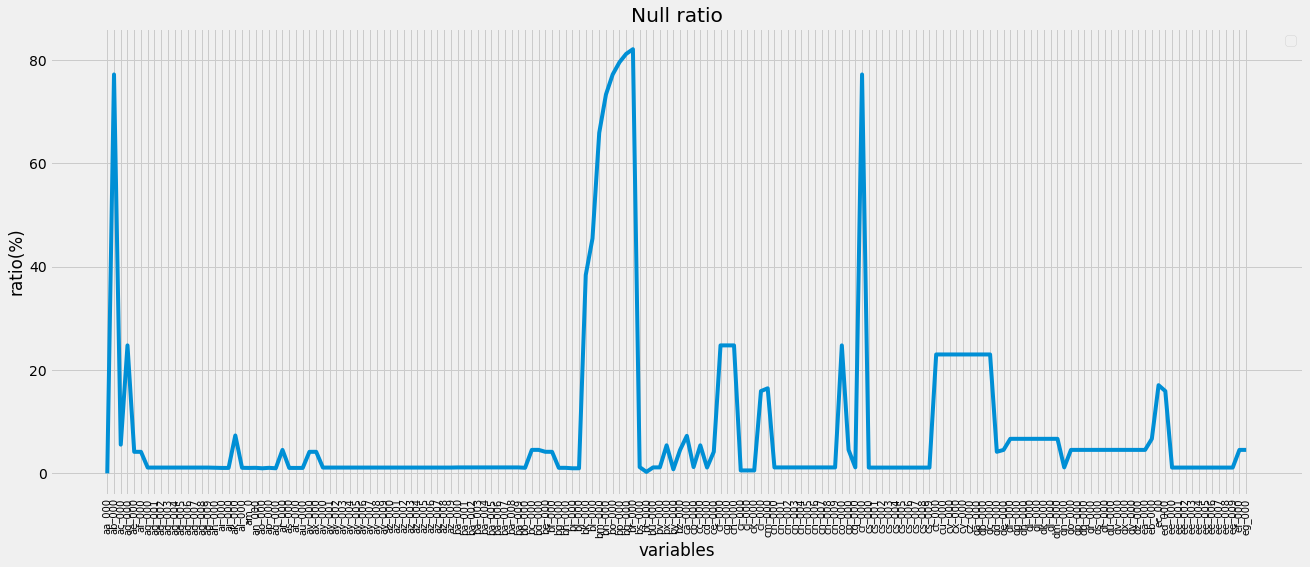

In [12]:
# Check by visualization
plt.figure(figsize=(20,8))
plt.plot(col, null_ratio)
plt.xlabel("variables")
plt.ylabel("ratio(%)")
plt.xticks(rotation=90, fontsize=10)
plt.title("Null ratio")
plt.legend()

Beberapa variabel memiliki persentase nilai Null yang sangat tinggi. Bagaimana cara menggunakan informasi ini? Perlu pertimbangan.

In [13]:
# data type check
train.dtypes

class      object
aa_000      int64
ab_000    float64
ac_000    float64
ad_000    float64
           ...   
ee_007    float64
ee_008    float64
ee_009    float64
ef_000    float64
eg_000    float64
Length: 171, dtype: object

# EDA
Pemeriksaan jumlah kelas

Text(0.5, 1.0, 'neg:59000 / pos:1000')

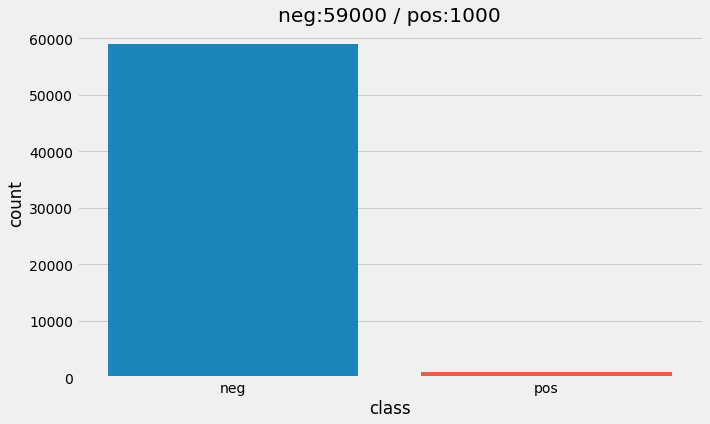

In [14]:
plt.figure(figsize=(10,6))
sns.countplot(train["class"])
plt.title("neg:{0} / pos:{1}".format(train["class"].value_counts()[0], train["class"].value_counts()[1]))

Periksa distribusi variabel secara numerik
Jumlah variabel adalah 171 yang sangat besar, jadi periksa dulu distribusi variabel secara numerik untuk mendapatkan karakteristiknya.

Ganti label kelas dengan angka untuk analisis nanti. 1: positif, 0: negatif.

In [15]:
# define function
def class_flg(x):
    if x["class"] == 'pos':
        res = 1
    else:
        res = 0
    return res

train["class"] = train.apply(class_flg, axis=1)
# test data
test["class"] = test.apply(class_flg, axis=1)

Memahami distribusi dan hubungan setiap data¶

In [16]:
# min and max and mean and std
col = train.iloc[:,1:].columns
mean = train.iloc[:,1:].mean()
min_ = train.iloc[:,1:].min()
max_ = train.iloc[:,1:].max()
std = train.iloc[:,1:].std()

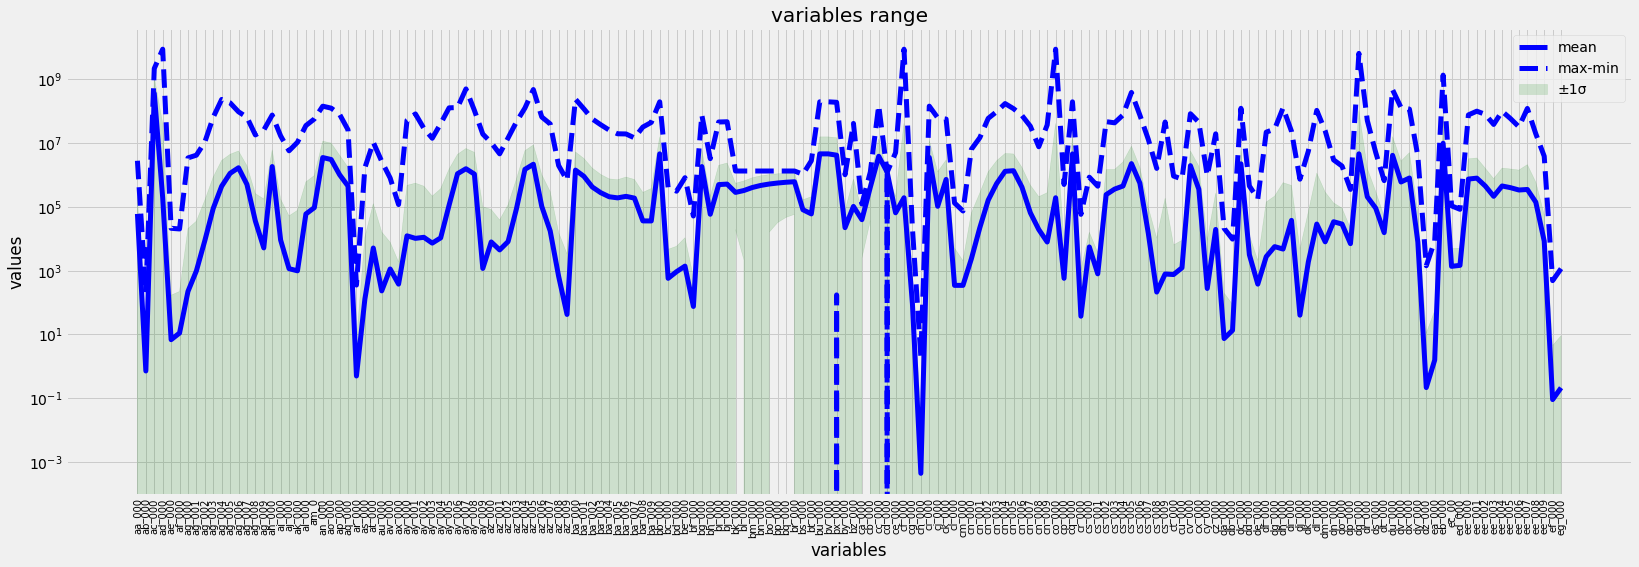

In [17]:
# Visualization by plot
plt.figure(figsize=(25,8))

plt.plot(col, mean, linewidth=5, color="blue", label='mean') #mean
plt.fill_between(col, mean+std, mean-std, alpha=0.15, color='green', label='±1σ') # ±1σ
plt.plot(col, min_, linewidth=5, color='blue', linestyle='--', label='max-min') # min
plt.plot(col, max_, linewidth=5, color='blue', linestyle='--') # max
plt.xlabel("variables")
plt.ylabel("values")
plt.yscale("log")
plt.xticks(rotation=90, fontsize=10)
plt.title("variables range")
plt.legend()

Ini bukan grafik yang terorganisir, tetapi Anda dapat melihat ukuran dan lebar variabel. Nilai absolut dari setiap nilai dapat berkisar dari angka yang cukup besar hingga yang kecil. Bahkan jika Anda menggunakan grafik logaritmik, grafiknya telah berubah secara signifikan, jadi berhati-hatilah saat menangani setiap skala.

**Perbedaan menurut label**

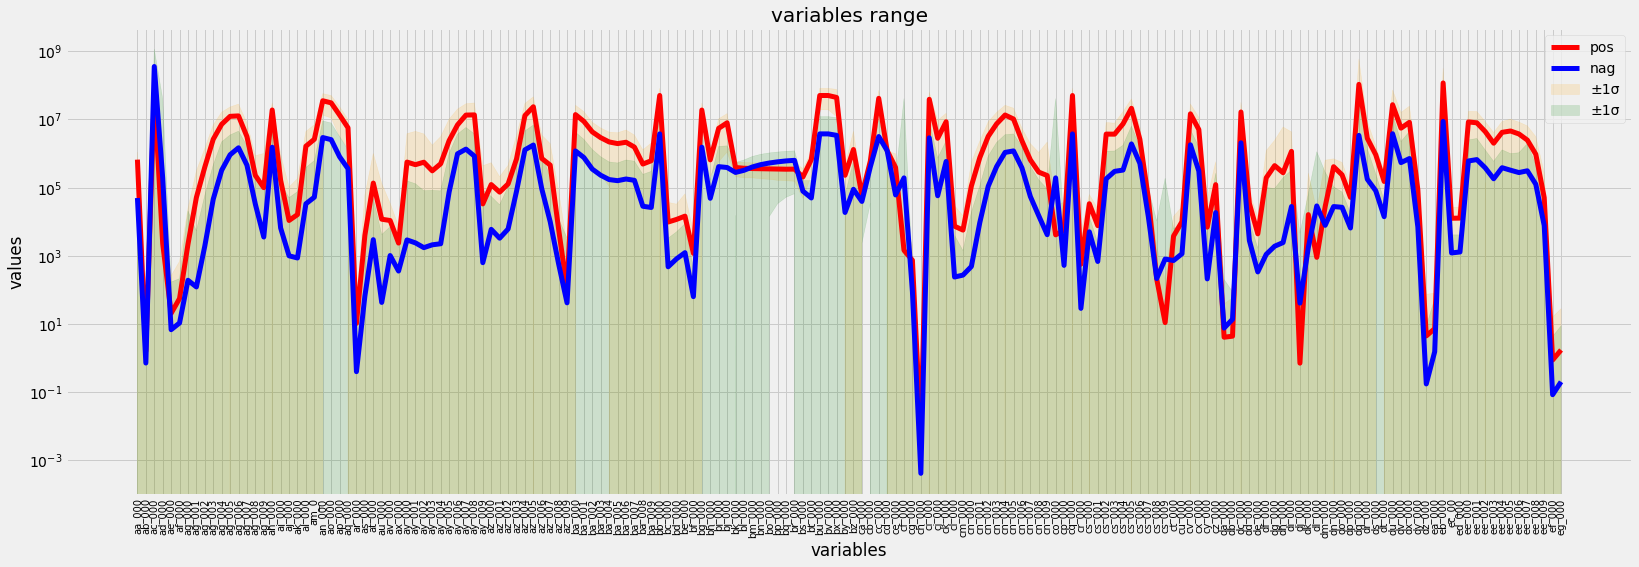

In [18]:
train_mean = train.groupby("class").mean().T
train_std = train.groupby("class").std().T

# Visualization by plot
plt.figure(figsize=(25,8))

plt.plot(train_mean.index, train_mean[1], linewidth=5, color="red", label='pos') #mean
plt.fill_between(train_mean.index, train_mean[1]+train_std[1], train_mean[1]-train_std[1], alpha=0.15, color='orange', label='±1σ') # ±1σ

plt.plot(train_mean.index, train_mean[0], linewidth=5, color="blue", label='nag') #mean
plt.fill_between(train_mean.index, train_mean[0]+train_std[0], train_mean[0]-train_std[0], alpha=0.15, color='green', label='±1σ') # ±1σ

plt.xlabel("variables")
plt.ylabel("values")
plt.yscale("log")
plt.xticks(rotation=90, fontsize=10)
plt.title("variables range")
plt.legend()

Saat memplot nilai rata-rata untuk setiap kelas, beberapa variabel memiliki nilai numerik yang hampir sama, tetapi sebagian besar dapat dikonfirmasi tergantung pada ukuran nilainya. Dari sini, dapat dilihat bahwa properti klasifikasi dari label kelas dapat diharapkan. Di sisi lain, ada beberapa variabel.
Akan menyenangkan untuk dapat menyimpulkan setiap hubungan mekanis di sini, tetapi tidak ada informasi seperti itu. Oleh karena itu, diputuskan untuk mengurangi dimensi dan mengubah data menjadi keadaan yang mudah untuk memahami karakteristik data.

# Correlation
Next, check the correlation of each variable with a heat map

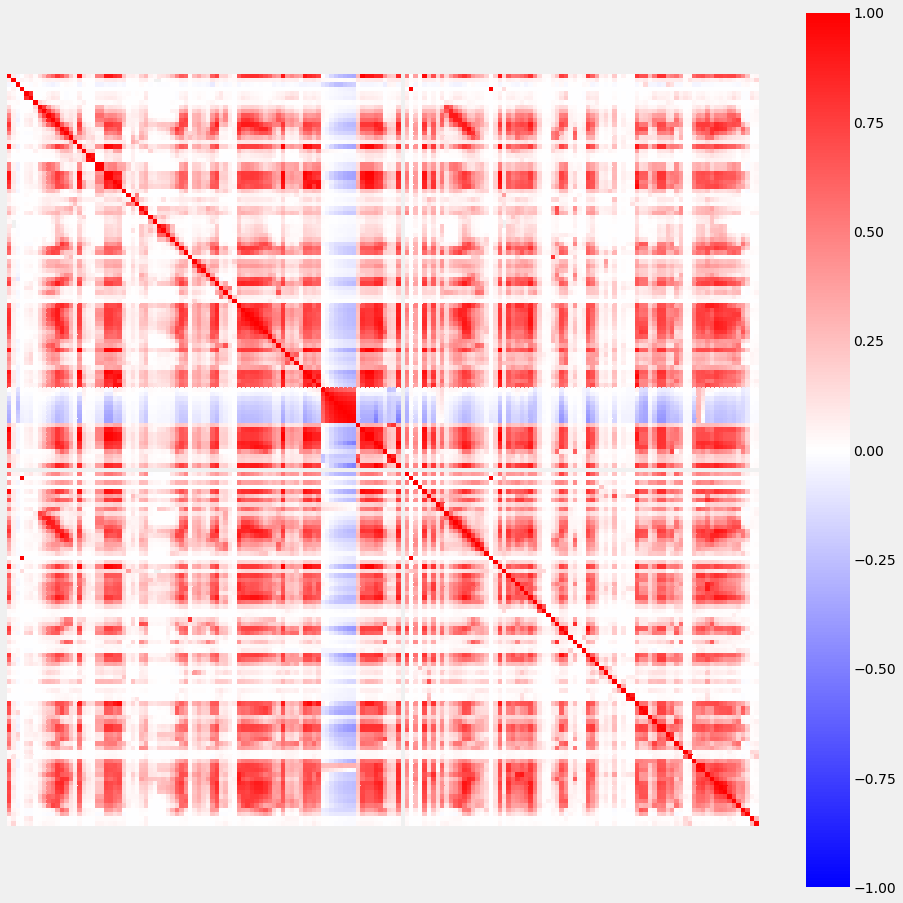

In [19]:
# Null data are tempolary filled mean value.
matrix = train.iloc[:,1:].iloc[1:].corr()
plt.figure(figsize=(15,15))
sns.heatmap(matrix, vmax=1, vmin=-1, cmap='bwr', square=True, annot=False, center=0, yticklabels=False, xticklabels=False)

Terlihat dari banyaknya variabel yang memiliki korelasi yang tinggi. Jika isi variabel dan hubungan teknisnya jelas, variabel dapat dipilih, tetapi kali ini tidak ada informasi sebelumnya. Oleh karena itu, perlu dilakukan ekstraksi variabel yang relevan dengan menggunakan analisis data.

# Skerness and kurtosis


In [20]:
# skew
col = train.iloc[:,1:].columns
# Roop, calculate with drop na values.
skew = []
for i in col:
    sk = scipy.stats.skew(train[i].dropna())
    skew.append(sk)

In [21]:
# kurtosis
# Roop, calculate with drop na values.
kurt = []
for i in col:
    ku = scipy.stats.kurtosis(train[i].dropna())
    kurt.append(ku)

Text(0.5, 1.0, 'Kurtosis')

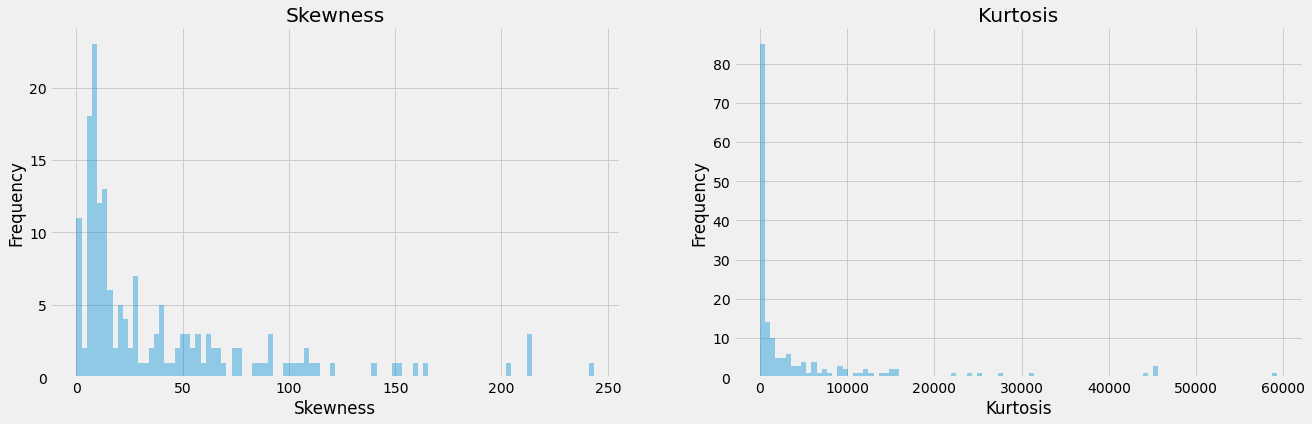

In [22]:
# check with graph
fig, ax = plt.subplots(1, 2, figsize=(20,6))
sns.distplot(skew, ax=ax[0], kde=False, bins=100)
ax[0].set_xlabel("Skewness")
ax[0].set_ylabel("Frequency")
ax[0].set_title("Skewness")
sns.distplot(kurt, ax=ax[1], kde=False, bins=100)
ax[1].set_xlabel("Kurtosis")
ax[1].set_ylabel("Frequency")
ax[1].set_title("Kurtosis")

Distribusi data dikonfirmasi. Pertama, hanya ditemukan nilai skewness yang lebih besar dari 0, dan sebarannya memiliki ekor kanan yang panjang dan bias ke kiri. Dikonfirmasi juga bahwa semua nilai sangat besar dan biasnya kuat. Terlihat banyak kurtosis yang mendekati 0 dan tidak berdistribusi tajam, namun beberapa kurtosis memiliki data dengan sebaran tajam yang besar.

# Pendekatan untuk mengekstrak fitur penting (important Feature)

**Direction**

Untuk mencari fitur penting dari sejumlah besar variabel, analisis dilakukan dengan menggunakan tiga pendekatan berikut.
1) PCA dan analisis klaster
2) Pemeriksaan kepentingan oleh pengklasifikasi hutan acak

Dari hasil ini, kami memutuskan untuk membuat penilaian yang komprehensif dan memutuskan fitur-fitur penting.

Oleh karena itu, pertama-tama kami melakukan standarisasi data dan mengkonfirmasi distribusinya, terutama untuk yang memiliki rasio nol melebihi 15%. Melihat distribusi, kami mempertimbangkan variabel yang datanya memiliki varians dan kemungkinan ada jumlah sampel yang cukup.

Adapun nilai-nilai Null lainnya, nilai-nilai dengan kepentingan yang tersisa dalam analisis kepentingan variabel berikutnya diadopsi, dan diputuskan untuk mengisinya dengan nilai rata-rata yang memiliki pengaruh statistik paling kecil.

In [23]:
# Data
label = train["class"]
X = train.iloc[:,1:]
col = train.iloc[:,1:].columns

# Scaling
# Create instance
sc = StandardScaler()
# Fitting
sc.fit(X)
# Transform
X_std = sc.fit_transform(X)

In [24]:
## test data
X_test_std = sc.fit_transform(test.iloc[1:])
Y_test = test["class"]

In [25]:
# Create data frame
train_std = pd.DataFrame(X_std, columns=col)
train_std["class"] = label
train_std.head()

,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,ag_004,ag_005,ag_006,ag_007,ag_008,ag_009,ah_000,ai_000,aj_000,ak_000,al_000,am_0,an_000,ao_000,ap_000,aq_000,ar_000,as_000,at_000,au_000,av_000,ax_000,ay_000,ay_001,ay_002,ay_003,ay_004,ay_005,ay_006,ay_007,...,dc_000,dd_000,de_000,df_000,dg_000,dh_000,di_000,dj_000,dk_000,dl_000,dm_000,dn_000,do_000,dp_000,dq_000,dr_000,ds_000,dt_000,du_000,dv_000,dx_000,dy_000,dz_000,ea_000,eb_000,ec_00,ed_000,ee_000,ee_001,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000,class
0,0.119381,NaN,2.232688,-0.004711,-0.042213,-0.052466,-0.010823,-0.02853,-0.057251,-0.116304,-0.168409,0.099458,0.513215,0.357317,-0.043942,-0.030148,0.177214,-0.055225,-0.022710,-0.012917,-0.10961,-0.109812,0.188987,0.095715,0.246678,0.546264,-0.090159,-0.011511,-0.042403,-0.014594,-0.016038,-0.071712,-0.026869,-0.019037,-0.025623,-0.034997,-0.029795,0.256017,0.964072,-0.165043,...,0.761523,0.168972,0.444542,-0.019796,-0.026898,-0.008401,-0.087553,-0.00881,-0.027949,-0.02605,-0.028549,0.293175,0.937081,1.851002,-0.046463,-0.149160,0.543012,0.666395,0.923857,0.615853,-0.190607,-0.131327,-0.019939,-0.029288,-0.161790,0.308960,0.357403,0.096212,0.359145,0.688022,0.519511,0.235649,0.067657,0.005703,-0.108976,-0.145729,-0.176720,-0.020733,-0.024093,0
1,-0.180697,NaN,-0.447891,NaN,-0.042213,-0.052466,-0.010823,-0.02853,-0.057251,-0.116304,-0.176410,-0.139485,0.016111,0.012240,-0.017842,-0.030148,-0.099524,-0.055225,-0.021360,-0.012917,-0.10961,-0.109812,-0.115546,-0.128352,0.026045,-0.082268,-0.090159,-0.011511,-0.042403,-0.014594,-0.169405,-0.252464,-0.026869,-0.019037,-0.025623,-0.034997,-0.029795,-0.029019,-0.093272,0.088304,...,NaN,0.019759,0.086944,-0.019796,-0.026898,-0.008401,-0.087553,-0.00881,-0.027949,-0.02605,-0.028549,-0.000097,0.137756,-0.073280,-0.046463,-0.149160,0.065682,0.025166,0.039020,0.131880,-0.190607,-0.131327,-0.019939,-0.029288,-0.145960,0.242783,0.250169,-0.028517,0.015672,-0.020847,-0.060853,-0.130470,-0.132494,-0.186507,-0.153429,-0.091554,-0.145121,-0.020733,-0.024093,0
2,-0.125811,NaN,-0.447891,-0.004715,-0.042213,-0.052466,-0.010823,-0.02853,-0.057251,-0.116304,-0.183404,-0.226134,0.057697,-0.145052,-0.106990,-0.030148,-0.137563,-0.055225,-0.022710,-0.012917,-0.10961,-0.109812,-0.139796,-0.121535,-0.227741,-0.228686,-0.090159,-0.011511,-0.042403,-0.014594,-0.115150,-0.178275,-0.026869,-0.019037,-0.025623,-0.034997,-0.029795,-0.080296,-0.063465,-0.255817,...,0.034134,-0.171276,-0.132114,-0.019796,-0.026898,-0.008401,-0.087553,-0.00881,-0.027949,-0.02605,-0.028549,-0.204132,0.157934,0.084509,-0.046463,-0.149160,-0.114712,-0.144061,-0.324912,-0.262032,-0.190607,-0.131327,-0.019939,-0.029288,-0.202987,-0.094580,-0.122597,-0.195093,-0.128593,-0.145485,-0.094447,-0.018610,0.013932,-0.011516,-0.108938,-0.097000,-0.165892,-0.020733,-0.024093,0
3,-0.407928,-0.205008,-0.447891,-0.004716,-0.042213,-0.004799,-0.010823,-0.02853,-0.057251,-0.115886,-0.183166,-0.338733,-0.423586,-0.350946,-0.161571,-0.030148,-0.431770,-0.055225,-0.022710,-0.012917,-0.10842,-0.105228,-0.442969,-0.439168,-0.321651,-0.349628,-0.090159,-0.011511,-0.042403,-0.014594,-0.160312,-0.248417,-0.026869,-0.019037,-0.025623,-0.034997,-0.029795,-0.080296,-0.328936,-0.302380,...,-0.534822,-0.320279,-0.185399,-0.019796,-0.026898,-0.008401,-0.087553,-0.00881,-0.027949,-0.02605,-0.028549,-0.344306,-0.465402,-0.498638,-0.046442,-0.148889,-0.430389,-0.455178,-0.349506,-0.284215,-0.185747,-0.130585,-0.019939,-0.029288,-0.227320,-0.382302,-0.396640,-0.301196,-0.304390,-0.385321,-0.388505,-0.381473,-0.351374,-0.311507,-0.200384,-0.308627,-0.176720,0.894847,3.599684,0
4,0.010572,NaN,-0.447889,-0.004707,-0.042213,-0.052466,-0.010823,-0.02853,-0.057251,-0.116304,-0.165670,0.263057,0.036457,-0.258417,-0.140731,-0.030148,0.039206,-0.055225,-0.018223,-0.012917,-0.10961,-0.109812,-0.029577,-0.056245,0.017477,0.086037,-0.090159,-0.011511,-0.042403,-0.014594,0.101564,0.180531,-0.026869,-0.019037,-0.025623,-0.034997

In [26]:
# Create test data frame
test_std = pd.DataFrame(X_test_std, columns=test.iloc[1:].columns)
test_std["class"] = Y_test
test_std.head()

,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,ag_004,ag_005,ag_006,ag_007,ag_008,ag_009,ah_000,ai_000,aj_000,ak_000,al_000,am_0,an_000,ao_000,ap_000,aq_000,ar_000,as_000,at_000,au_000,av_000,ax_000,ay_000,ay_001,ay_002,ay_003,ay_004,ay_005,ay_006,...,db_000,dc_000,dd_000,de_000,df_000,dg_000,dh_000,di_000,dj_000,dk_000,dl_000,dm_000,dn_000,do_000,dp_000,dq_000,dr_000,ds_000,dt_000,du_000,dv_000,dx_000,dy_000,dz_000,ea_000,eb_000,ec_00,ed_000,ee_000,ee_001,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,0,-0.134885,-0.298270,-0.449437,-0.257544,-0.054395,-0.060963,-0.018725,-0.023128,-0.058485,-0.109797,-0.175280,-0.319250,-0.416951,-0.363565,-0.148400,-0.033751,-0.419783,-0.051913,-0.023169,-0.010264,-0.109192,-0.110705,-0.429365,-0.425410,-0.307312,-0.343075,-0.103842,-0.01208,-0.044727,-0.01177,-0.174403,-0.203378,-0.024962,-0.02404,-0.027083,-0.035488,-0.032688,-0.113048,-0.329433,...,-0.557886,-0.561454,-0.298717,-0.248141,-0.013266,-0.03311,-0.020313,-0.080056,-0.018644,-0.019844,-0.024977,-0.025852,-0.340212,-0.404926,-0.449922,-0.045035,-0.144753,-0.412682,-0.434813,-0.342142,-0.275473,-0.192617,-0.124938,-0.019756,-0.032764,-0.181050,-0.384366,-0.367800,-0.268792,-0.314936,-0.369565,-0.379056,-0.368822,-0.337881,-0.296664,-0.216121,-0.268777,-0.160619,-0.019253,-0.016926
1,0,-0.003970,0.474172,-0.449437,-0.211132,-0.054395,-0.060963,-0.018725,-0.023128,-0.058485,0.084664,0.310595,0.213090,-0.306450,-0.345523,-0.146252,-0.033751,-0.005746,-0.051913,-0.024332,-0.010264,0.010791,-0.001542,-0.006497,0.015133,-0.034057,-0.136351,-0.103842,-0.01208,-0.044727,-0.01177,-0.161172,-0.031425,-0.024962,-0.02404,-0.027083,-0.035488,-0.032688,-0.081385,-0.124400,...,-0.557886,0.359069,0.075997,0.236158,-0.013266,-0.03311,-0.020313,-0.080056,-0.018644,-0.019844,-0.024977,-0.025852,-0.103228,-0.277301,-0.295531,0.079923,0.779655,0.072029,0.083932,-0.344366,-0.274981,0.905671,0.977538,-0.019756,-0.032764,0.258682,0.190253,0.168769,-0.135024,-0.104838,0.024007,0.273052,-0.022866,-0.123965,0.799536,-0.122038,-0.267815,-0.160619,-0.019253,-0.016926
2,0,-0.016256,NaN,-0.449436,0.320027,-0.054395,-0.060963,-0.018725,-0.023128,-0.058485,-0.109797,-0.131203,-0.052584,-0.004442,0.451486,0.234152,0.048147,-0.031830,-0.051913,-0.024332,-0.010264,-0.107473,-0.108363,-0.013476,-0.016955,-0.123716,-0.037189,-0.103842,-0.01208,0.012709,-0.01177,0.052204,0.029891,-0.024962,-0.02404,-0.027083,-0.035488,-0.032688,-0.104719,-0.001054,...,1.460845,0.308032,-0.041124,0.029662,-0.013266,-0.03311,-0.019875,0.007156,-0.018644,-0.019844,-0.024977,-0.025852,-0.079821,0.046101,-0.059629,-0.045083,-0.145176,0.177568,0.144457,-0.129682,-0.089820,-0.194196,-0.125498,-0.019756,-0.032764,-0.161097,0.045823,0.043500,-0.043863,-0.044560,0.060451,0.037839,0.011190,0.047347,0.062882,-0.087409,0.255908,-0.099980,-0.019253,-0.016926
3,0,-0.131445,NaN,-0.449437,-0.193083,-0.054395,-0.060963,-0.018725,-0.023128,-0.058485,-0.109797,-0.175522,-0.317787,-0.397463,-0.361329,-0.148400,-0.033751,-0.410184,-0.051913,-0.024332,-0.010264,-0.109192,-0.110705,-0.420634,-0.415753,-0.310451,-0.340305,-0.103842,-0.01208,-0.044727,-0.01177,-0.161735,-0.224705,-0.024962,-0.02404,-0.027083,-0.035488,-0.032688,-0.097997,-0.307291,...,-0.557886,-0.539129,-0.298717,-0.251113,-0.013266,-0.03311,-0.020313,-0.080056,-0.018644,-0.019844,-0.024977,-0.025852,-0.338443,-0.400058,-0.441166,-0.045083,-0.145176,-0.405502,-0.427118,-0.344951,-0.276920,-0.190807,-0.123787,-0.019756,-0.032764,-0.167289,-0.353328,-0.380848,-0.268731,-0.312324,-0.364324,-0.372420,-0.355532,-0.298450,-0.294088,-0.216108,-0.268635,-0.160619,-0.019253,-0.016926
4,0,-0.134702,NaN,-0.449438,-0.267858,-0.054395,-0.060963,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.419311,-0.051913,-0.021735,-0.010264,-0.109192,-0.110705,-0.429425,-0.425163,-0.309979,-0.343424,-0.103842,-0.01208,-0.044727,-0.01177,-0.170462,-0.175386,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.557886,-0.560300,-0.301070,

In [27]:
# Null value
null_df = pd.DataFrame({"variables":train.iloc[:,1:].columns,
                        "null_ratio":null_ratio})
null_over15_col = null_df[null_df["null_ratio"]>15]["variables"]

In [28]:
# Result columns
null_over15_col

1      ab_000
3      ad_000
71     bk_000
72     bl_000
73     bm_000
74     bn_000
75     bo_000
76     bp_000
77     bq_000
78     br_000
91     cf_000
92     cg_000
93     ch_000
97     cl_000
98     cm_000
109    co_000
112    cr_000
123    ct_000
124    cu_000
125    cv_000
126    cx_000
127    cy_000
128    cz_000
129    da_000
130    db_000
131    dc_000
156     ec_00
157    ed_000
Name: variables, dtype: object

In [29]:
# null ratio df
null_ratio_df = pd.DataFrame({"variables":train_std[null_over15_col].isnull().sum().index, 
                             "null_ratio":train_std[null_over15_col].isnull().sum()/len(train_std)*100}).sort_values(by="null_ratio", ascending=False)

# over 15% null value df
null_df = train_std[null_ratio_df["variables"]]

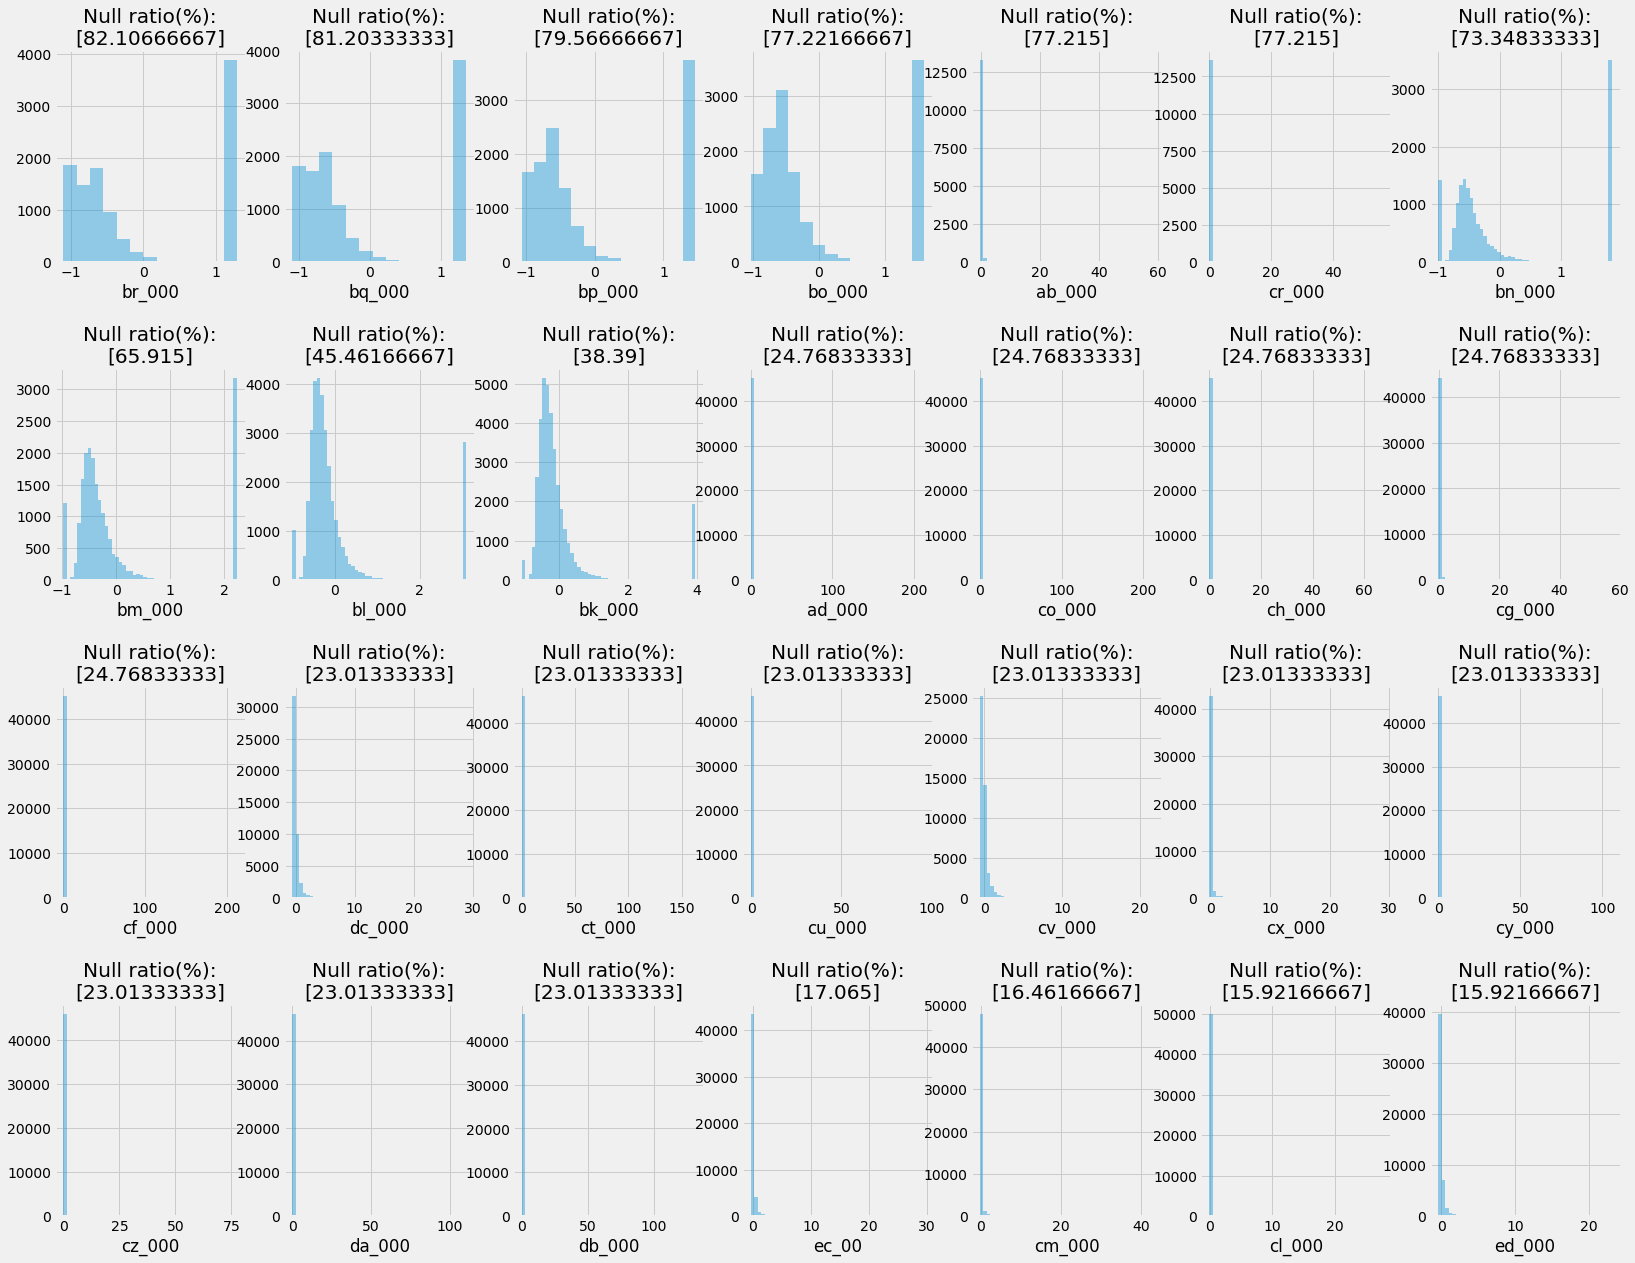

In [30]:
# distribution check
col = null_df.columns
fig, ax = plt.subplots(4, 7, figsize=(25, 20))
plt.subplots_adjust(hspace=0.5)
for i in range(len(col)):
    if i <= 6:
        sns.distplot(null_df[col[i]], ax=ax[0,i], kde=False)
        ax[0,i].set_title("Null ratio(%):\n{}".format(null_ratio_df[null_ratio_df["variables"]==col[i]]["null_ratio"].values))
    if i > 6 and i <= 13:
        sns.distplot(null_df[col[i]], ax=ax[1,i-7], kde=False)
        ax[1,i-7].set_title("Null ratio(%):\n{}".format(null_ratio_df[null_ratio_df["variables"]==col[i]]["null_ratio"].values))
    if i > 13 and i <= 20:
        sns.distplot(null_df[col[i]], ax=ax[2,i-14], kde=False)
        ax[2,i-14].set_title("Null ratio(%):\n{}".format(null_ratio_df[null_ratio_df["variables"]==col[i]]["null_ratio"].values))
    if i > 20 and i <= 27:
        sns.distplot(null_df[col[i]], ax=ax[3,i-21], kde=False)
        ax[3,i-21].set_title("Null ratio(%):\n{}".format(null_ratio_df[null_ratio_df["variables"]==col[i]]["null_ratio"].values))

Sebagai hasil dari konfirmasi distribusi, diputuskan untuk meninggalkan bl_000 dan bk_000 karena rasio nilai nol adalah 40 hingga 50% dan ada lebih dari setengah data, dan data juga tersebar dan kemungkinan memiliki informasi. .. Variabel lain dikeluarkan karena jumlah datanya kecil dan biasnya hampir satu.

In [31]:
# Columns of drop
drop_col = null_over15_col.values
drop_col = np.delete(drop_col, np.where((drop_col == 'bl_000') & (drop_col == 'bk_000')))
# Checking
drop_col

array(['ab_000', 'ad_000', 'bk_000', 'bl_000', 'bm_000', 'bn_000',
       'bo_000', 'bp_000', 'bq_000', 'br_000', 'cf_000', 'cg_000',
       'ch_000', 'cl_000', 'cm_000', 'co_000', 'cr_000', 'ct_000',
       'cu_000', 'cv_000', 'cx_000', 'cy_000', 'cz_000', 'da_000',
       'db_000', 'dc_000', 'ec_00', 'ed_000'], dtype=object)

In [32]:
# Drop over15% null columns, and fill mean values
train_std.drop(drop_col, axis=1, inplace=True)

# Roop fill mean
for i in train_std.columns:
    mean = train_std[i].mean()
    train_std[i].fillna(mean, inplace=True)
    
train_std.head()

,aa_000,ac_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,ag_004,ag_005,ag_006,ag_007,ag_008,ag_009,ah_000,ai_000,aj_000,ak_000,al_000,am_0,an_000,ao_000,ap_000,aq_000,ar_000,as_000,at_000,au_000,av_000,ax_000,ay_000,ay_001,ay_002,ay_003,ay_004,ay_005,ay_006,ay_007,ay_008,ay_009,...,cs_007,cs_008,cs_009,dd_000,de_000,df_000,dg_000,dh_000,di_000,dj_000,dk_000,dl_000,dm_000,dn_000,do_000,dp_000,dq_000,dr_000,ds_000,dt_000,du_000,dv_000,dx_000,dy_000,dz_000,ea_000,eb_000,ee_000,ee_001,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000,class
0,0.119381,2.232688,-0.042213,-0.052466,-0.010823,-0.02853,-0.057251,-0.116304,-0.168409,0.099458,0.513215,0.357317,-0.043942,-0.030148,0.177214,-0.055225,-0.022710,-0.012917,-0.10961,-0.109812,0.188987,0.095715,0.246678,0.546264,-0.090159,-0.011511,-0.042403,-0.014594,-0.016038,-0.071712,-0.026869,-0.019037,-0.025623,-0.034997,-0.029795,0.256017,0.964072,-0.165043,-0.073978,-0.011868,...,0.144391,-0.009233,-0.004227,0.168972,0.444542,-0.019796,-0.026898,-0.008401,-0.087553,-0.00881,-0.027949,-0.02605,-0.028549,0.293175,0.937081,1.851002,-0.046463,-0.149160,0.543012,0.666395,0.923857,0.615853,-0.190607,-0.131327,-0.019939,-0.029288,-0.161790,0.096212,0.359145,0.688022,0.519511,0.235649,0.067657,0.005703,-0.108976,-0.145729,-0.176720,-0.020733,-0.024093,0
1,-0.180697,-0.447891,-0.042213,-0.052466,-0.010823,-0.02853,-0.057251,-0.116304,-0.176410,-0.139485,0.016111,0.012240,-0.017842,-0.030148,-0.099524,-0.055225,-0.021360,-0.012917,-0.10961,-0.109812,-0.115546,-0.128352,0.026045,-0.082268,-0.090159,-0.011511,-0.042403,-0.014594,-0.169405,-0.252464,-0.026869,-0.019037,-0.025623,-0.034997,-0.029795,-0.029019,-0.093272,0.088304,-0.238426,-0.011868,...,-0.070248,-0.018688,-0.004227,0.019759,0.086944,-0.019796,-0.026898,-0.008401,-0.087553,-0.00881,-0.027949,-0.02605,-0.028549,-0.000097,0.137756,-0.073280,-0.046463,-0.149160,0.065682,0.025166,0.039020,0.131880,-0.190607,-0.131327,-0.019939,-0.029288,-0.145960,-0.028517,0.015672,-0.020847,-0.060853,-0.130470,-0.132494,-0.186507,-0.153429,-0.091554,-0.145121,-0.020733,-0.024093,0
2,-0.125811,-0.447891,-0.042213,-0.052466,-0.010823,-0.02853,-0.057251,-0.116304,-0.183404,-0.226134,0.057697,-0.145052,-0.106990,-0.030148,-0.137563,-0.055225,-0.022710,-0.012917,-0.10961,-0.109812,-0.139796,-0.121535,-0.227741,-0.228686,-0.090159,-0.011511,-0.042403,-0.014594,-0.115150,-0.178275,-0.026869,-0.019037,-0.025623,-0.034997,-0.029795,-0.080296,-0.063465,-0.255817,0.100022,-0.011868,...,0.023867,0.003374,-0.004227,-0.171276,-0.132114,-0.019796,-0.026898,-0.008401,-0.087553,-0.00881,-0.027949,-0.02605,-0.028549,-0.204132,0.157934,0.084509,-0.046463,-0.149160,-0.114712,-0.144061,-0.324912,-0.262032,-0.190607,-0.131327,-0.019939,-0.029288,-0.202987,-0.195093,-0.128593,-0.145485,-0.094447,-0.018610,0.013932,-0.011516,-0.108938,-0.097000,-0.165892,-0.020733,-0.024093,0
3,-0.407928,-0.447891,-0.042213,-0.004799,-0.010823,-0.02853,-0.057251,-0.115886,-0.183166,-0.338733,-0.423586,-0.350946,-0.161571,-0.030148,-0.431770,-0.055225,-0.022710,-0.012917,-0.10842,-0.105228,-0.442969,-0.439168,-0.321651,-0.349628,-0.090159,-0.011511,-0.042403,-0.014594,-0.160312,-0.248417,-0.026869,-0.019037,-0.025623,-0.034997,-0.029795,-0.080296,-0.328936,-0.302380,-0.261970,-0.011868,...,-0.184526,-0.020855,-0.004227,-0.320279,-0.185399,-0.019796,-0.026898,-0.008401,-0.087553,-0.00881,-0.027949,-0.02605,-0.028549,-0.344306,-0.465402,-0.498638,-0.046442,-0.148889,-0.430389,-0.455178,-0.349506,-0.284215,-0.185747,-0.130585,-0.019939,-0.029288,-0.227320,-0.301196,-0.304390,-0.385321,-0.388505,-0.381473,-0.351374,-0.311507,-0.200384,-0.308627,-0.176720,0.894847,3.599684,0
4,0.010572,-0.447889,-0.042213,-0.052466,-0.010823,-0.02853,-0.057251,-0.116304,-0.165670,0.263057,0.036457,-0.258417,-0.140731,-0.030148,0.039206,-0.055225,-0.018223,-0.012917,-0.10961,-0.109812,-0.029577,-0.056245,0.017477,0.086037,-0.090159,-0.011511,-0.042403,-0.014594,0.101564,0.180531,-0.026869,-0.019037,

In [33]:
# Drop over15% null columns, and fill mean values
test_std.drop(drop_col, axis=1, inplace=True)

# Roop fill mean
for i in test_std.columns:
    mean = test_std[i].mean()
    test_std[i].fillna(mean, inplace=True)
    
test_std.head()

,class,aa_000,ac_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,ag_004,ag_005,ag_006,ag_007,ag_008,ag_009,ah_000,ai_000,aj_000,ak_000,al_000,am_0,an_000,ao_000,ap_000,aq_000,ar_000,as_000,at_000,au_000,av_000,ax_000,ay_000,ay_001,ay_002,ay_003,ay_004,ay_005,ay_006,ay_007,ay_008,...,cs_006,cs_007,cs_008,cs_009,dd_000,de_000,df_000,dg_000,dh_000,di_000,dj_000,dk_000,dl_000,dm_000,dn_000,do_000,dp_000,dq_000,dr_000,ds_000,dt_000,du_000,dv_000,dx_000,dy_000,dz_000,ea_000,eb_000,ee_000,ee_001,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,0,-0.134885,-0.449437,-0.054395,-0.060963,-1.872541e-02,-2.312778e-02,-5.848543e-02,-1.097971e-01,-1.752803e-01,-3.192504e-01,-4.169514e-01,-3.635647e-01,-1.484003e-01,-3.375116e-02,-0.419783,-0.051913,-0.023169,-0.010264,-0.109192,-0.110705,-0.429365,-0.425410,-0.307312,-0.343075,-0.103842,-0.01208,-0.044727,-0.01177,-0.174403,-0.203378,-2.496244e-02,-2.403989e-02,-2.708267e-02,-3.548764e-02,-3.268778e-02,-1.130478e-01,-3.294326e-01,-3.179807e-01,-2.235705e-01,...,-4.911575e-01,-3.427954e-01,-1.257025e-02,-7.974940e-03,-0.298717,-0.248141,-0.013266,-0.03311,-0.020313,-0.080056,-0.018644,-0.019844,-0.024977,-0.025852,-0.340212,-0.404926,-0.449922,-0.045035,-0.144753,-0.412682,-0.434813,-0.342142,-0.275473,-0.192617,-0.124938,-0.019756,-0.032764,-0.181050,-2.687923e-01,-3.149357e-01,-3.695649e-01,-3.790558e-01,-3.688220e-01,-3.378815e-01,-2.966640e-01,-2.161207e-01,-2.687767e-01,-1.606190e-01,-0.019253,-0.016926
1,0,-0.003970,-0.449437,-0.054395,-0.060963,-1.872541e-02,-2.312778e-02,-5.848543e-02,8.466355e-02,3.105947e-01,2.130905e-01,-3.064502e-01,-3.455229e-01,-1.462522e-01,-3.375116e-02,-0.005746,-0.051913,-0.024332,-0.010264,0.010791,-0.001542,-0.006497,0.015133,-0.034057,-0.136351,-0.103842,-0.01208,-0.044727,-0.01177,-0.161172,-0.031425,-2.496244e-02,-2.403989e-02,-2.708267e-02,-3.548764e-02,-3.268778e-02,-8.138457e-02,-1.244005e-01,2.411679e-01,-1.357517e-01,...,-2.079089e-01,-2.345812e-01,-1.531760e-02,-7.974940e-03,0.075997,0.236158,-0.013266,-0.03311,-0.020313,-0.080056,-0.018644,-0.019844,-0.024977,-0.025852,-0.103228,-0.277301,-0.295531,0.079923,0.779655,0.072029,0.083932,-0.344366,-0.274981,0.905671,0.977538,-0.019756,-0.032764,0.258682,-1.350239e-01,-1.048378e-01,2.400685e-02,2.730523e-01,-2.286644e-02,-1.239647e-01,7.995359e-01,-1.220378e-01,-2.678155e-01,-1.606190e-01,-0.019253,-0.016926
2,0,-0.016256,-0.449436,-0.054395,-0.060963,-1.872541e-02,-2.312778e-02,-5.848543e-02,-1.097971e-01,-1.312034e-01,-5.258436e-02,-4.441773e-03,4.514861e-01,2.341523e-01,4.814706e-02,-0.031830,-0.051913,-0.024332,-0.010264,-0.107473,-0.108363,-0.013476,-0.016955,-0.123716,-0.037189,-0.103842,-0.01208,0.012709,-0.01177,0.052204,0.029891,-2.496244e-02,-2.403989e-02,-2.708267e-02,-3.548764e-02,-3.268778e-02,-1.047194e-01,-1.053772e-03,2.655075e-01,-2.263045e-01,...,3.386277e-01,5.266861e-01,-4.244953e-03,-7.974940e-03,-0.041124,0.029662,-0.013266,-0.03311,-0.019875,0.007156,-0.018644,-0.019844,-0.024977,-0.025852,-0.079821,0.046101,-0.059629,-0.045083,-0.145176,0.177568,0.144457,-0.129682,-0.089820,-0.194196,-0.125498,-0.019756,-0.032764,-0.161097,-4.386296e-02,-4.455973e-02,6.045068e-02,3.783894e-02,1.118997e-02,4.734652e-02,6.288206e-02,-8.740928e-02,2.559082e-01,-9.998039e-02,-0.019253,-0.016926
3,0,-0.131445,-0.449437,-0.054395,-0.060963,-1.872541e-02,-2.312778e-02,-5.848543e-02,-1.097971e-01,-1.755222e-01,-3.177872e-01,-3.974634e-01,-3.613290e-01,-1.484003e-01,-3.375116e-02,-0.410184,-0.051913,-0.024332,-0.010264,-0.109192,-0.110705,-0.420634,-0.415753,-0.310451,-0.340305,-0.103842,-0.01208,-0.044727,-0.01177,-0.161735,-0.224705,-2.496244e-02,-2.403989e-02,-2.708267e-02,-3.548764e-02,-3.268778e-02,-9.799715e-02,-3.072910e-01,-3.173893e-01,-2.237842e-01,...,-4.424736e-01,-3.480039e-01,-1.207073e-02,-7.974940e-03,-0.298717,-0.251113,-0.013266,-0.03311,-0.020313,-0.080056,-0.018644,-0.019844,-0.024977,-0.025852,-0.338443,-0.400058,-0.441166,-0.045083,-0.145176,-0.405502,-0.42711

In [34]:
train_std.corr().isnull().sum()

aa_000    1
ac_000    1
ae_000    1
af_000    1
ag_000    1
         ..
ee_008    1
ee_009    1
ef_000    1
eg_000    1
class     1
Length: 143, dtype: int64

Beberapa data memiliki varians nol. Hilangkan karena tidak mempengaruhi hasil analisis dan menjadi risiko komputasi.

In [35]:
# Sumber kesalahan yang terjadi selama analisis
train_std["cd_000"].var()

0.0

In [36]:
train_std.drop("cd_000", axis=1, inplace=True)
# test data
test_std.drop("cd_000", axis=1, inplace=True)

In [37]:
# Difine variables
X = train_std.iloc[:,:-1]
Y = train_std["class"]

# K-Means Clustering¶


Check with cluster numbers, by elbow method.

Text(0, 0.5, 'Distortion')

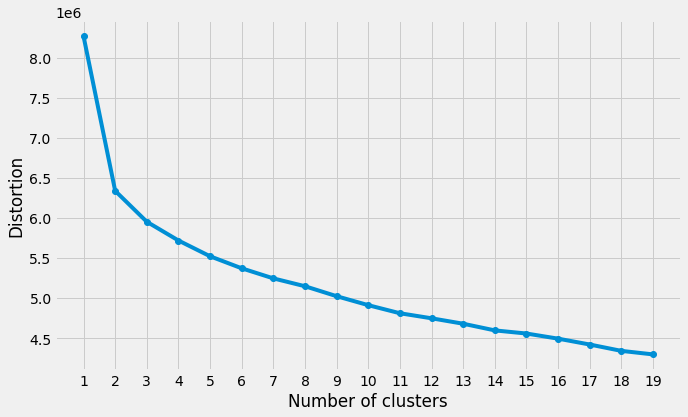

In [38]:
# Calculation of distiortions
distortions = []
for i in range(1,20):
    km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=10)
    km.fit(X)
    distortions.append(km.inertia_)
    
# Plotting 
plt.figure(figsize=(10,6))
plt.plot(range(1,20), distortions, marker='o')
plt.xlabel("Number of clusters")
plt.xticks(range(1,20))
plt.ylabel("Distortion")

Dapat dilihat bahwa distorsi berkurang dengan bertambahnya jumlah cluster. Secara khusus, dapat dilihat bahwa jumlah cluster sangat berkurang menjadi 4 dan kemudian secara bertahap berkurang. Kali ini, kami memutuskan untuk melanjutkan analisis, dengan asumsi bahwa jumlah cluster di mana kurva ini asimtotik adalah hingga 8.

In [39]:
# Clustering n=8
kmeans = KMeans(n_clusters=8, init='k-means++', n_init=10, max_iter=100, random_state=10)

In [41]:
# Fitting
kmeans.fit(X)
# output
cluster = kmeans.labels_

In [42]:
# test data fit transform and labels
cluster_test = kmeans.fit_predict(test_std.iloc[:,:-1])

# PCA

Untuk menentukan jumlah komponen utama, kami mengkonfirmasi peluruhan nilai eigen dari varians dengan plot scree.

**Scree plot**


Text(0.5, 1.0, 'Scale up')

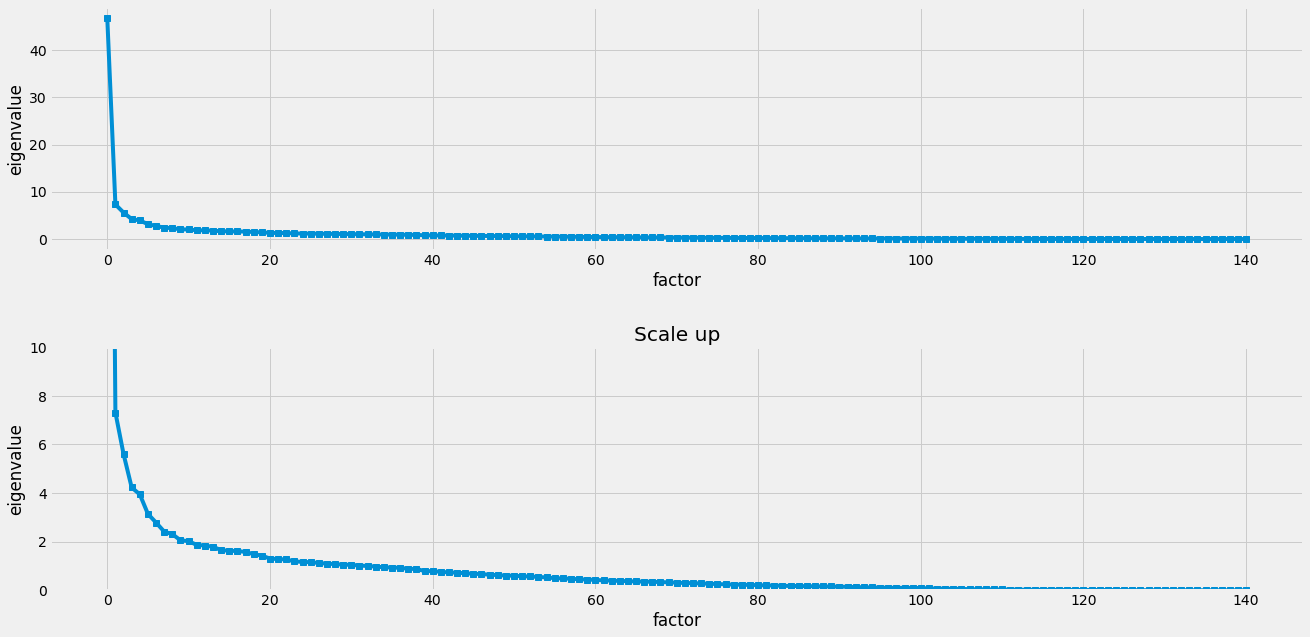

In [43]:
eigen_vals = sorted(np.linalg.eigvals(X.corr()), reverse=True)

# plot
fig, ax = plt.subplots(2, 1, figsize=(20,10))
plt.subplots_adjust(hspace=0.4)
ax[0].plot(eigen_vals, 's-')
ax[0].set_xlabel("factor")
ax[0].set_ylabel("eigenvalue")

ax[1].plot(eigen_vals, 's-')
ax[1].set_xlabel("factor")
ax[1].set_ylabel("eigenvalue")
ax[1].set_ylim([0,10])
ax[1].set_title("Scale up")

Sebagai hasil dari konfirmasi nilai eigen menggunakan nilai varians, sangat mungkin bahwa bahkan dua dapat menjelaskan sebagian besar dari keseluruhan data, dan bahkan jika ada 10 variabel, seluruh data dapat diungkapkan dengan informasi yang cukup. Saya mengerti.

In [44]:
# Create instance, n=10
pca = PCA(n_components=10)

# Fitting
pca_result = pca.fit_transform(X)
pca_result = pd.DataFrame(pca_result, columns=["pca1","pca2","pca3","pca4","pca5","pca6","pca7","pca8","pca9","pca10"])

pca_result.head()

,pca1,pca2,pca3,pca4,pca5,pca6,pca7,pca8,pca9,pca10
0,2.067060,-1.650569,-1.173050,-0.222624,0.800675,-0.554636,0.351157,1.280963,-0.560372,-0.131025
1,-0.661134,-0.480705,-0.000431,-0.026358,0.056128,-0.268854,0.105288,-0.103587,0.080509,-0.146282
2,-1.229649,-0.103018,0.345223,-0.227798,0.157963,0.102483,-0.127858,-0.405450,0.514269,-0.088100
3,-3.068150,0.444135,0.631020,0.138870,-0.223796,0.360775,0.002274,-0.958007,1.004540,0.872115
4,0.196044,-0.416048,-0.725250,-0.511433,0.347641,-0.117599,0.004450,1.031958,-0.962476,-0.040146


Text(93.559375, 0.5, 'variables')

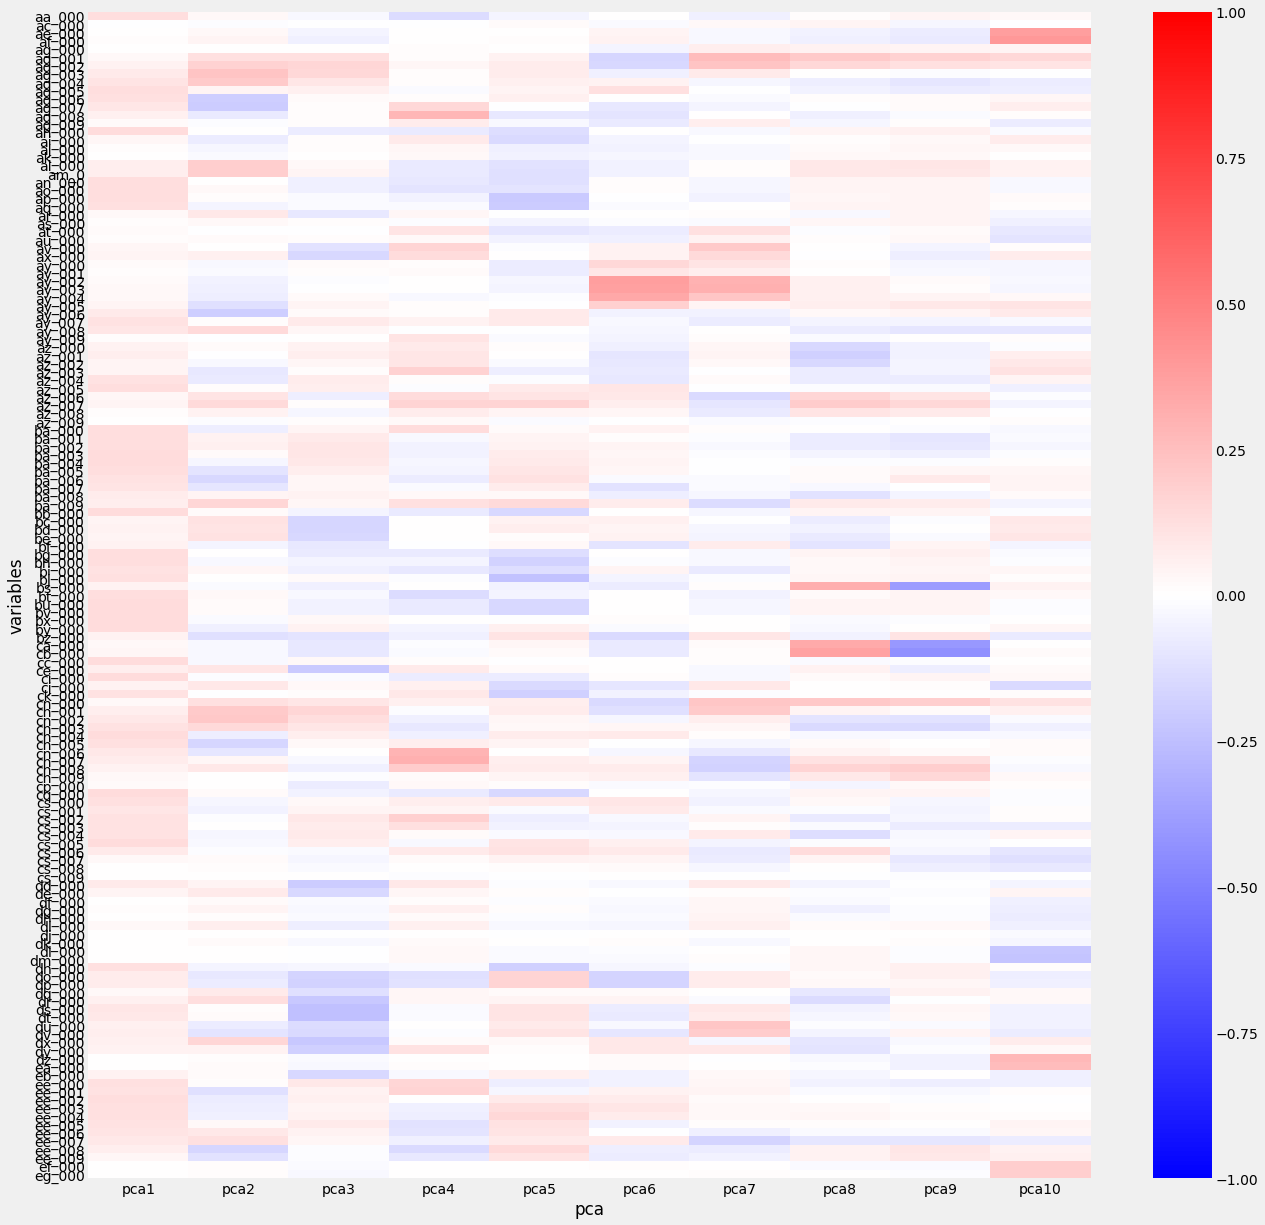

In [45]:
# Visualization by heatmap
plt.figure(figsize=(20,20))
sns.heatmap(pca.components_.T, vmax=1, vmin=-1, cmap='bwr', square=False, annot=False, center=0, yticklabels=X.columns, xticklabels=pca_result.columns)
plt.xlabel("pca")
plt.ylabel("variables")

Meskipun hubungan jumlah fitur berbeda untuk setiap komponen utama, kekuatan variabel yang terkait dengan informasi data dapat dilihat dari gambar ini. Dapat juga dilihat bahwa selama ini terdapat variabel-variabel yang tidak berhubungan dengan komponen utama.

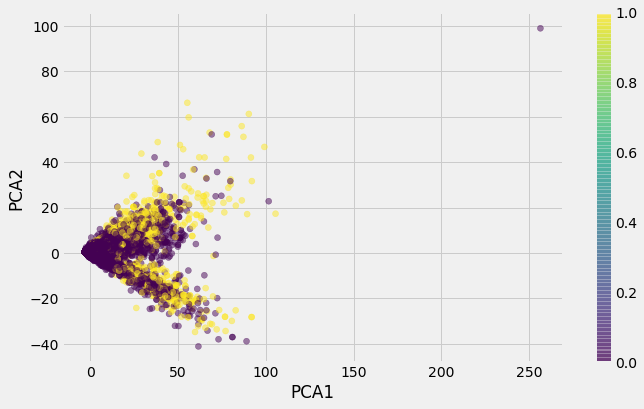

In [46]:
# Visualization by plot
x = pca_result["pca1"]
y = pca_result["pca2"]
color = Y

plt.figure(figsize=(10,6))
plt.scatter(x, y, c=color, alpha=0.5)
plt.xlabel("PCA1")
plt.ylabel("PCA2")
plt.colorbar()

Sebagian besar dari dua sumbu komponen utama tumpang tindih ketika diplot oleh label kelas, tetapi daerah dengan sejumlah besar kelas positif dan daerah dengan kelas negatif padat dan padat dipisahkan.

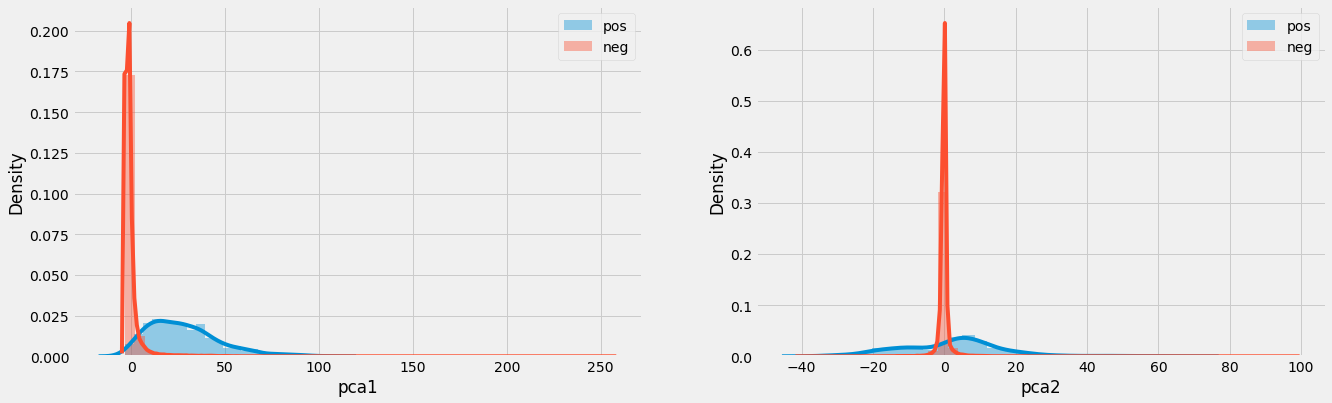

In [47]:
# create dataframe
pca_result["class"] = Y

fig, ax = plt.subplots(1,2,figsize=(20,6))
sns.distplot(pca_result[pca_result["class"]==1]["pca1"], label="pos", ax=ax[0])
sns.distplot(pca_result[pca_result["class"]==0]["pca1"], label="neg", ax=ax[0])
ax[0].legend()

sns.distplot(pca_result[pca_result["class"]==1]["pca2"], label="pos", ax=ax[1])
sns.distplot(pca_result[pca_result["class"]==0]["pca2"], label="neg", ax=ax[1])
ax[1].legend()

Lebih mudah untuk memahami distribusi setiap sumbu komponen utama yang diplot. Mengenai sumbu pca1, kelas positif bias menuju nilai yang lebih besar, dan kelas negatif mengelompok di sekitar 0. Sumbu pca2 tersebar luas dari nilai negatif ke nilai positif di kelas positif, tetapi bias mendekati 0 di negatif kelas.

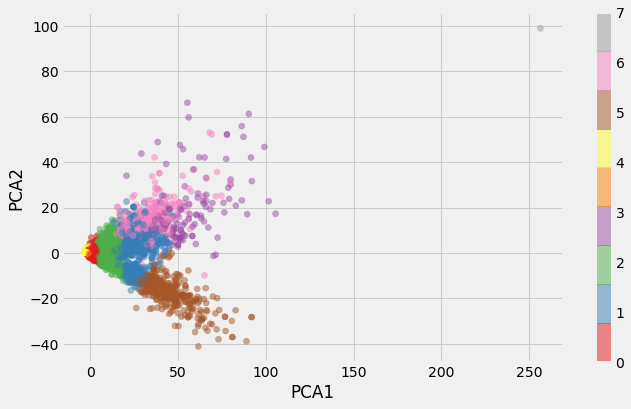

In [48]:
pca_result["cluster"] = cluster

# Visualization by plot
x = pca_result["pca1"]
y = pca_result["pca2"]

plt.figure(figsize=(10,6))
plt.scatter(x, y, c=cluster, alpha=0.5, cmap="Set1")
plt.xlabel("PCA1")
plt.ylabel("PCA2")
plt.colorbar()

In [49]:
# pivot count 
pivot = pd.pivot_table(data=pca_result, index="class", columns="cluster", values="pca1", aggfunc="count", fill_value=0)
pivot.columns = ["c1", "c2", "c3", "c4", "c5", "c6", "c7", "c8"]
pivot.reset_index()

,class,c1,c2,c3,c4,c5,c6,c7,c8
0,0,26334,540,3030,43,28608,212,232,1
1,1,55,310,226,89,9,209,102,0


Selanjutnya, ketika hasil analisis klaster diplot, dipastikan bahwa klaster dapat dibagi bahkan pada sumbu komponen utama.
Apakah cluster ini membagi kelas positif dan negatif untuk label kelas? dikonfirmasi. Akibatnya, cluster 1 dan cluster 5 dapat membentuk cluster yang memiliki sejumlah besar kelas negatif. Ini adalah titik tajam di sisi kiri grafik plot. (Catatan: area kuning dan merah di plot)

Selanjutnya, saya juga mengkonfirmasi bagaimana variabel lain berbeda dalam cluster..
Namun, cluster 8 jumlahnya kecil dan merupakan outlier, sehingga dikecualikan.

In [50]:
# Characteristics of each cluster
# Create dataframe
cluster_name = ["c1", "c2", "c3", "c4", "c5", "c6", "c7"]
pca_label = ["pca1","pca2","pca3","pca4","pca5","pca6","pca7","pca8","pca9","pca10"]

cluster_stats = pd.DataFrame({"cluster":range(0,7)})
cluster_pos_mean = pd.merge(cluster_stats, pca_result[pca_result["class"]==1].groupby("cluster").mean()[pca_label].reset_index(),
                            left_on="cluster", right_on="cluster", how="left").drop("cluster", axis=1)
cluster_pos_std = pd.merge(cluster_stats, pca_result[pca_result["class"]==1].groupby("cluster").std()[pca_label].reset_index(),
                            left_on="cluster", right_on="cluster", how="left").drop("cluster", axis=1)
cluster_neg_mean = pd.merge(cluster_stats, pca_result[pca_result["class"]==0].groupby("cluster").mean()[pca_label].reset_index(),
                            left_on="cluster", right_on="cluster", how="left").drop("cluster", axis=1)
cluster_neg_std = pd.merge(cluster_stats, pca_result[pca_result["class"]==0].groupby("cluster").std()[pca_label].reset_index(),
                            left_on="cluster", right_on="cluster", how="left").drop("cluster", axis=1)

# Change name of columns
cluster_pos_mean.index = cluster_name
cluster_pos_std.index = cluster_name
cluster_neg_mean.index = cluster_name
cluster_neg_std.index = cluster_name

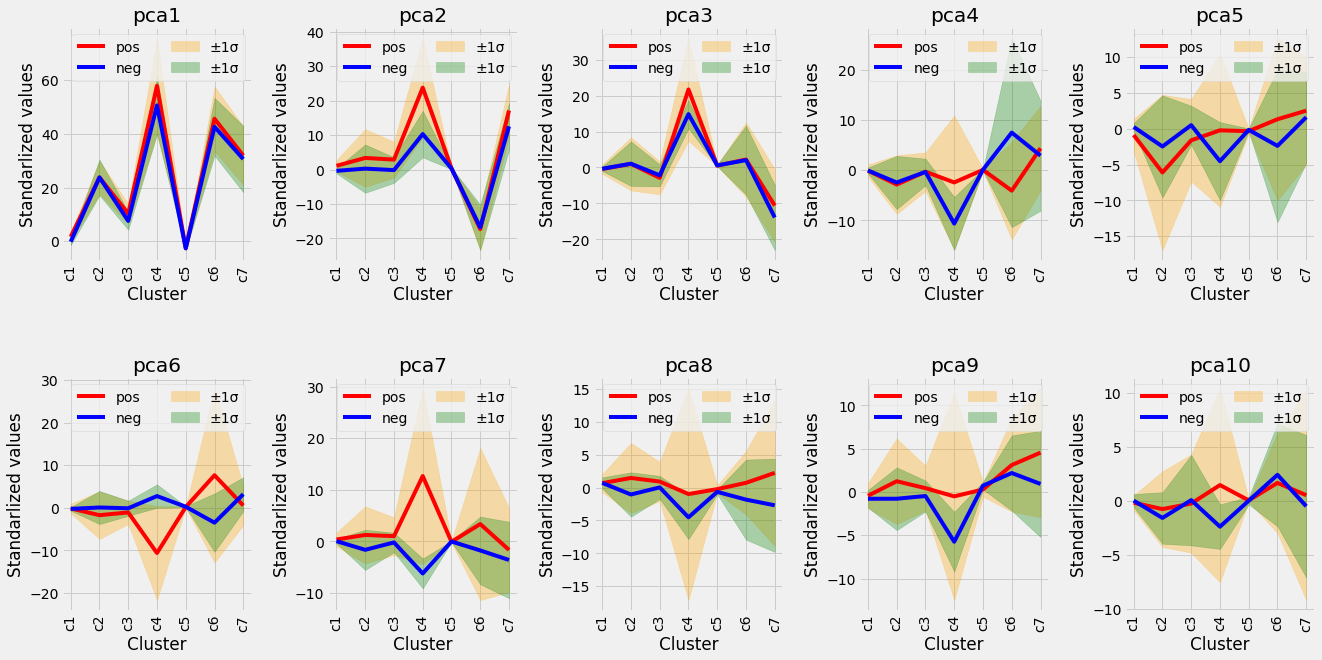

In [51]:
# Visualization
fig, ax = plt.subplots(2,5,figsize=(20,10))
plt.subplots_adjust(hspace=0.5, wspace=0.4)

for i in range(len(cluster_pos_mean.columns)):
    if i <5:
        ax[0,i].plot(cluster_pos_mean.index, cluster_pos_mean[pca_label[i]], color="red", label="pos")
        ax[0,i].fill_between(cluster_pos_mean.index, cluster_pos_mean[pca_label[i]]+cluster_pos_std[pca_label[i]],
                             cluster_pos_mean[pca_label[i]]-cluster_pos_std[pca_label[i]], color="orange", alpha=0.3, label="±1σ")
        ax[0,i].plot(cluster_neg_mean.index, cluster_neg_mean[pca_label[i]], color="blue", label="neg")
        ax[0,i].fill_between(cluster_neg_mean.index, cluster_neg_mean[pca_label[i]]+cluster_neg_std[pca_label[i]],
                             cluster_neg_mean[pca_label[i]]-cluster_neg_std[pca_label[i]], color="green", alpha=0.3, label="±1σ")
        ax[0,i].set_title(pca_label[i])
        ax[0,i].set_xlabel("Cluster")
        ax[0,i].set_ylabel("Standarlized values")
        ax[0,i].tick_params(axis='x', labelrotation=90)
        ax[0,i].legend(ncol=2)
    else:
        ax[1,i-5].plot(cluster_pos_mean.index, cluster_pos_mean[pca_label[i]], color="red", label="pos")
        ax[1,i-5].fill_between(cluster_pos_mean.index, cluster_pos_mean[pca_label[i]]+cluster_pos_std[pca_label[i]],
                               cluster_pos_mean[pca_label[i]]-cluster_pos_std[pca_label[i]], color="orange", alpha=0.3, label="±1σ")
        ax[1,i-5].plot(cluster_neg_mean.index, cluster_neg_mean[pca_label[i]], color="blue", label="neg")
        ax[1,i-5].fill_between(cluster_neg_mean.index, cluster_neg_mean[pca_label[i]]+cluster_neg_std[pca_label[i]],
                               cluster_neg_mean[pca_label[i]]-cluster_neg_std[pca_label[i]], color="green", alpha=0.3, label="±1σ")
        ax[1,i-5].set_title(pca_label[i])
        ax[1,i-5].set_xlabel("Cluster")
        ax[1,i-5].set_ylabel("Standarlized values")
        ax[1,i-5].tick_params(axis='x', labelrotation=90)
        ax[1,i-5].legend(ncol=2)

Sebagai hasil dari konfirmasi setiap komponen utama selain pca1 dan pca2, karakteristik komponen utama diklasifikasikan untuk setiap cluster. Point of interest adalah cluster 1 dan 5 yang sebagian besar termasuk dalam kelas negatif tadi, namun dengan melihat masing-masing sumbu dapat diketahui bahwa cluster lain dapat memiliki nilai yang sama. Artinya tidak mungkin membuat suatu penilaian dengan hanya satu variabel saja, hal ini menunjukkan perlunya membuat suatu penilaian positif/negatif yang mencakup hubungan antar masing-masing variabel.

Di sisi lain, cluster 4, 6 dan 7 adalah cluster yang memiliki sejumlah besar kelas positif, dan dapat dipastikan bahwa nilainya juga merupakan karakteristik. Faktanya, memahami karakteristik kluster ini akan membantu menganalisis mekanisme mekanis.

# Feature importance analysis dengan menggunakan Random forest

Selanjutnya, kami menganalisis pentingnya fitur menggunakan pendekatan yang sama sekali berbeda. Prediksi klasifikasi dilakukan di hutan acak, dan pentingnya fitur diekstraksi menggunakan perolehan informasi yang merupakan fitur dari pohon keputusan.

Ada masalah besar dalam mengklasifikasikan. Artinya, ada bias yang besar antara kelas positif dan negatif. Dalam kasus seperti itu, melengkapi menggunakan metode oversampling atau metode undersampling, dan menyeimbangkan setiap kelas untuk membuat model.
Kali ini, hanya metode oversampling yang digunakan karena hanya fitur kuantitas fitur yang penting. Juga, untuk referensi, sebagai hasil dari analisis klaster, klaster yang memiliki banyak kelas negatif dapat diapit. Oleh karena itu, kami mencoba membangun model dengan sampel data tidak termasuk cluster.

Untuk metode lain dari data yang tidak seimbang, efeknya diverifikasi ketika membangun model prediksi setelah analisis kepentingan ini.

**Konfirmasi pentingnya fitur, dengan metode oversampling**.

# Over sampling method

Eksekusi pengklasifikasi Random Forest

In [52]:
# Difine variables
X = train_std.iloc[:,:-1]
Y = train_std["class"]

# Data preprocessing, oversampling method
# create instance
ros = RandomOverSampler(sampling_strategy="auto", random_state=10)

# train test data split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=10)

# Apply to data
X_resampled, y_resampled = ros.fit_sample(X_train, y_train)


In [53]:
# Create instance
forest  = RandomForestClassifier(n_estimators=10, random_state=10)

In [54]:
# parameters
param_range = [10,15,20]
leaf = [70, 75, 80, 85]
criterion = ["entropy", "gini", "error"]
param_grid = [{"max_depth":param_range, "criterion":criterion, "max_leaf_nodes":leaf}]

# Optimization by Grid search, scoring is f1 score
gs = GridSearchCV(estimator=forest, param_grid=param_grid, scoring="f1", cv=5, n_jobs=-1)
gs = gs.fit(X_resampled, y_resampled)

In [55]:
print("gs best:%.3f" % gs.best_score_)
print("gs params:{}".format(gs.best_params_))

gs best:0.988
gs params:{'criterion': 'entropy', 'max_depth': 15, 'max_leaf_nodes': 85}


In [56]:
# Prediction
gs_best = gs.best_estimator_

y_pred = gs_best.predict(X_test)

In [58]:
#Scores
print("Confusion_matrix = \n", confusion_matrix(y_true=y_test, y_pred=y_pred))
print("accuracy = %.3f" % accuracy_score(y_true=y_test, y_pred=y_pred))
print("precision = %.3f" % precision_score(y_true=y_test, y_pred=y_pred))
print("recall = %.3f" % recall_score(y_true=y_test, y_pred=y_pred))
print("f1_score = %.3f" % f1_score(y_true=y_test, y_pred=y_pred))

Confusion_matrix = 
 [[11534   268]
 [   13   185]]
accuracy = 0.977
precision = 0.408
recall = 0.934
f1_score = 0.568


Hasil untuk data pelatihan memberikan ekstraksi yang solid dari kelas positif. Namun, skor presisi rendah karena seluruh data tidak seimbang. Meskipun ini merupakan masalah, dapat dievaluasi bahwa nilai recall tinggi dan kelas positif dapat diklasifikasikan untuk sementara waktu.
Dari hasil model ini diperoleh derajat kepentingan jumlah fitur.

In [59]:
# Create best model of random forest classifier
forest  = RandomForestClassifier(n_estimators=10, random_state=10, criterion="entropy", max_depth=15, max_leaf_nodes=60)
forest.fit(X_resampled, y_resampled)

importance = forest.feature_importances_

indices = np.argsort(importance)[::-1]

# Due to the large number of items, only the top 30 were written.
for i in range(30):
    print("%2d) %-*s %f" %(i+1, 10, X.columns[indices[i]], importance[indices[i]]))

 1) ck_000     0.171225
 2) ci_000     0.154040
 3) bt_000     0.073563
 4) bh_000     0.068968
 5) aq_000     0.066512
 6) bg_000     0.065670
 7) az_000     0.063073
 8) ba_003     0.053188
 9) bv_000     0.018742
10) bj_000     0.018458
11) bx_000     0.016892
12) cs_004     0.013266
13) cs_002     0.012372
14) ba_001     0.011885
15) ai_000     0.009203
16) ag_002     0.008716
17) dn_000     0.006669
18) am_0       0.006566
19) ay_008     0.006440
20) aa_000     0.006288
21) al_000     0.004902
22) cq_000     0.004225
23) bb_000     0.004054
24) ee_005     0.004022
25) ah_000     0.003934
26) bc_000     0.003911
27) bs_000     0.003856
28) cn_001     0.003658
29) ap_000     0.003468
30) cj_000     0.003419


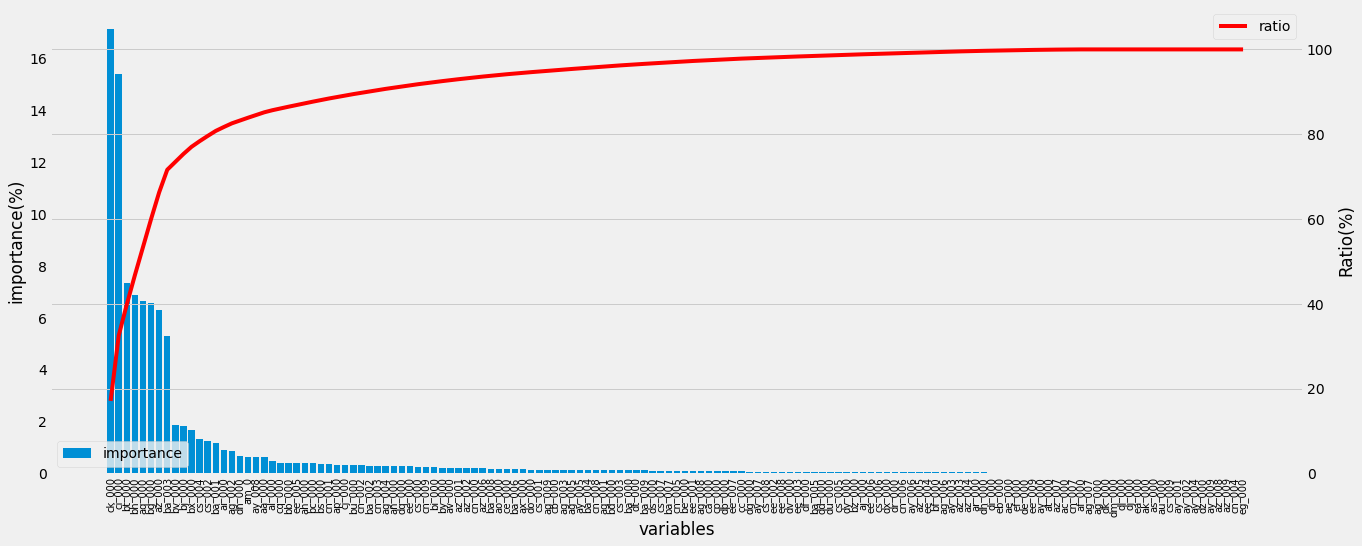

In [60]:
# Visualization with paret0 graph
forest_importance1 = pd.DataFrame({})
variables = []
feature_importance1 = []
for i in range(len(indices)):
    col = X.columns[indices[i]]
    impor = importance[indices[i]]
    variables.append(col)
    feature_importance1.append(impor)
forest_importance1["variables"] = variables
forest_importance1["feature_importance1"] = feature_importance1
forest_importance1["feature_importance1"] = forest_importance1["feature_importance1"]*100
forest_importance1["cumsum"] = forest_importance1["feature_importance1"].cumsum()


# Graph
fig, ax1 = plt.subplots(figsize=(20,8))
ax1.bar(forest_importance1["variables"], forest_importance1["feature_importance1"], label="importance")
ax1.grid()
ax1.set_xlabel("variables")
ax1.tick_params(axis='x', rotation=90, labelsize=10)
ax1.set_ylabel("importance(%)")
plt.legend(loc='lower left')
ax2 = ax1.twinx()
ax2.plot(forest_importance1["variables"], forest_importance1["cumsum"], color="red", label="ratio")
ax2.set_ylim([0,110])
ax2.set_ylabel("Ratio(%)")
plt.legend(loc="upper right")

Tentang hasil klasifikasi hutan secara acak ini, ditemukan bahwa sekitar 1/4 variabel dapat menjelaskan lebih dari 90% klasifikasi, dan 2/3 variabel dapat menjelaskan hampir 100%.

# Analisis kepentingan fitur dengan menggunakan hasil Random Forest dan Clustering

Dari hasil analisis klaster diketahui bahwa kedua klaster tersebut hampir tidak mengandung label positif. Dengan menghapus cluster ini, jumlah kelas positif dan negatif didekatkan, dan analisis serupa dilakukan.

In [61]:
train_std["cluster"] = cluster
# Create variable data and label data by removing the cluster data of c1 and c5 (0th and 4th in the label).

# test data
test_std["cluster"] = cluster_test

In [62]:
# Difine variables
X = train_std.query("cluster!=0 & cluster!=4").iloc[:,:-2]
Y = train_std.query("cluster!=0 & cluster!=4")["class"]

# train test data split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=10)

# Create instance
forest  = RandomForestClassifier(n_estimators=10, random_state=10)

# parameters
param_range = [5, 10,15]
leaf = [60, 65, 70, 75]
criterion = ["entropy", "gini", "error"]
param_grid = [{"max_depth":param_range, "criterion":criterion, "max_leaf_nodes":leaf}]

# Optimization by Grid search, scoring is f1
gs = GridSearchCV(estimator=forest, param_grid=param_grid, scoring="f1", cv=5, n_jobs=-1)
gs = gs.fit(X_train, y_train)

print("gs best:%.3f" % gs.best_score_)
print("gs params:{}".format(gs.best_params_))

gs best:0.752
gs params:{'criterion': 'entropy', 'max_depth': 10, 'max_leaf_nodes': 75}


In [63]:
# Prediction
gs_best = gs.best_estimator_

y_pred = gs_best.predict(X_test)

# Scores
print("Confusion_matrix = \n", confusion_matrix(y_true=y_test, y_pred=y_pred))
print("accuracy = %.3f" % accuracy_score(y_true=y_test, y_pred=y_pred))
print("precision = %.3f" % precision_score(y_true=y_test, y_pred=y_pred))
print("recall = %.3f" % recall_score(y_true=y_test, y_pred=y_pred))
print("f1_score = %.3f" % f1_score(y_true=y_test, y_pred=y_pred))

Confusion_matrix = 
 [[793  23]
 [ 55 128]]
accuracy = 0.922
precision = 0.848
recall = 0.699
f1_score = 0.766


Hasil untuk data pelatihan memberikan ekstraksi yang solid dari kelas positif. Skor presisi 84%. Meskipun ini merupakan masalah, dapat dievaluasi bahwa nilai recall rendah dan kelas positif dapat diklasifikasikan untuk sementara waktu. Dari hasil model ini diperoleh derajat kepentingan jumlah fitur.

In [64]:
# Create best model of random forest classifier
forest  = RandomForestClassifier(n_estimators=10, random_state=10, criterion="entropy", max_depth=15, max_leaf_nodes=60)
forest.fit(X_train, y_train)

importance = forest.feature_importances_

indices = np.argsort(importance)[::-1]

# Due to the large number of items, only the top 30 were written.
for i in range(30):
    print("%2d) %-*s %f" %(i+1, 10, X.columns[indices[i]], importance[indices[i]]))

 1) ci_000     0.076268
 2) ag_002     0.069606
 3) bj_000     0.042377
 4) bh_000     0.038221
 5) am_0       0.037117
 6) ag_003     0.035311
 7) bt_000     0.032755
 8) aq_000     0.032748
 9) ck_000     0.027386
10) ay_005     0.027222
11) ag_001     0.027138
12) al_000     0.022869
13) by_000     0.021743
14) cn_000     0.020870
15) az_001     0.020354
16) cn_001     0.018296
17) ao_000     0.016795
18) ay_008     0.014682
19) ay_009     0.014299
20) ee_007     0.013690
21) ag_006     0.013553
22) ee_005     0.012424
23) cs_001     0.011871
24) cs_002     0.011065
25) ee_008     0.010861
26) ay_007     0.010511
27) ai_000     0.010043
28) ee_004     0.009979
29) ay_006     0.009503
30) bb_000     0.008720


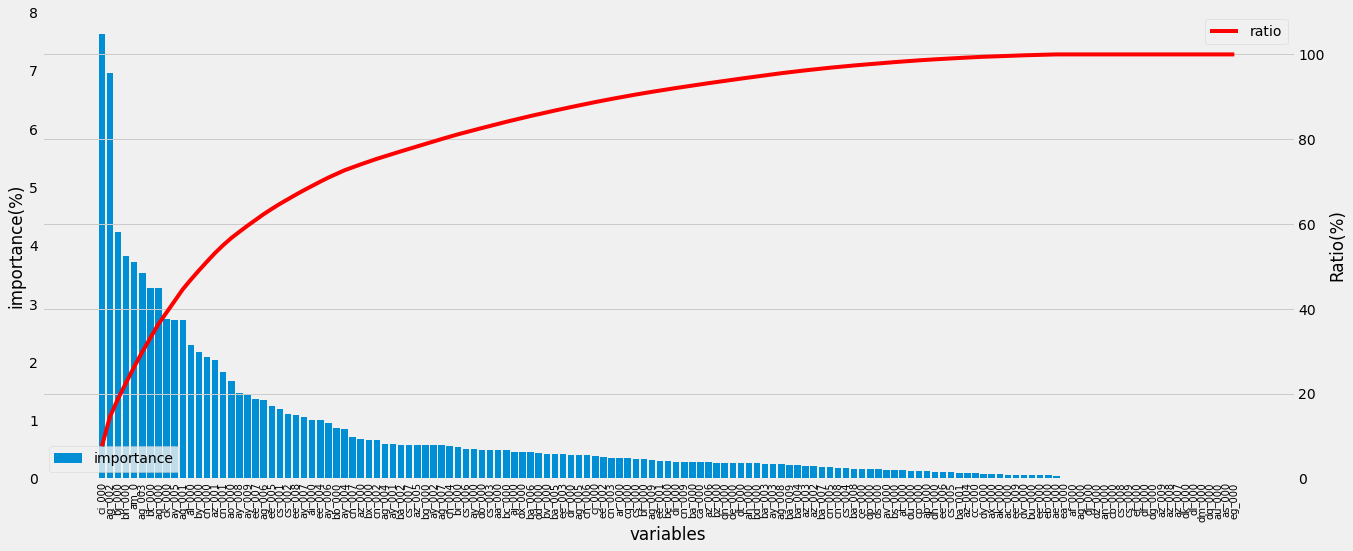

In [65]:
# Visualization with paret0 graph
forest_importance2 = pd.DataFrame({})
variables = []
feature_importance2 = []
for i in range(len(indices)):
    col = X.columns[indices[i]]
    impor = importance[indices[i]]
    variables.append(col)
    feature_importance2.append(impor)
forest_importance2["variables"] = variables
forest_importance2["feature_importance2"] = feature_importance2
forest_importance2["feature_importance2"] = forest_importance2["feature_importance2"]*100
forest_importance2["cumsum"] = forest_importance2["feature_importance2"].cumsum()


# Graph
fig, ax1 = plt.subplots(figsize=(20,8))
ax1.bar(forest_importance2["variables"], forest_importance2["feature_importance2"], label="importance")
ax1.grid()
ax1.set_xlabel("variables")
ax1.tick_params(axis='x', rotation=90, labelsize=10)
ax1.set_ylabel("importance(%)")
plt.legend(loc='lower left')
ax2 = ax1.twinx()
ax2.plot(forest_importance2["variables"], forest_importance2["cumsum"], color="red", label="ratio")
ax2.set_ylim([0,110])
ax2.set_ylabel("Ratio(%)")
plt.legend(loc="upper right")

Dari hasil tersebut, kita dapat melihat peningkatan nilai presisi. Di sisi lain, nilai recall mengalami penurunan, namun secara keseluruhan skornya baik. Distribusi derajat kepentingan variabel telah berubah dari hasil sebelumnya. Garis dengan lebih dari 90% memiliki hampir setengah jumlah variabel, dan asimtotik hingga 100% sekitar 4/5. Dengan kata lain, variabel yang memberikan hasil yang tidak begitu penting dengan pelatihan secara keseluruhan menjadi lebih penting pada cluster dengan konsentrasi kelas positif yang tinggi, dan menjadi variabel yang diperlukan untuk klasifikasi. Itu mungkin untuk meningkatkan kinerja klasifikasi dengan menggabungkan analisis cluster.
Juga, jika ada variabel yang ditemukan tidak signifikan baik dalam hasil keseluruhan dan hasil ini, kemungkinan mereka dapat dikeluarkan dari model jika isinya dikonfirmasi dan penjelasan logis diberikan.

# Deteksi fitur yang tidak pnting (unimportant features)


In [66]:
forest_importance = pd.merge(forest_importance1.drop("cumsum", axis=1), forest_importance2.drop("cumsum", axis=1),
                             left_on="variables", right_on="variables", how='left')
forest_importance

,variables,feature_importance1,feature_importance2
0,ck_000,17.122470,2.738599
1,ci_000,15.403972,7.626821
2,bt_000,7.356341,3.275535
3,bh_000,6.896824,3.822111
4,aq_000,6.651226,3.274783
...,...,...,...
136,ay_009,0.000000,1.429883
137,az_008,0.000000,0.000000
138,az_009,0.000000,0.000000
139,cn_004,0.000000,0.560119



Kedua kepentingan menghitung jumlah masing-masing rasio.

In [68]:
count = []
ratio = []
for i in range(0,11):
    r = i*0.1
    c = forest_importance[(forest_importance["feature_importance1"]<=i*0.1) & (forest_importance["feature_importance2"]<=i*0.1)]["variables"].count()
    count.append(c)
    ratio.append(r)
    
pd.DataFrame({"Both ratio(%)<":ratio,
              "count":count})

,Both ratio(%)<,count
0,0.0,13
1,0.1,27
2,0.2,42
3,0.3,62
4,0.4,76
5,0.5,88
6,0.6,99
7,0.7,102
8,0.8,103
9,0.9,105


Mereka yang memiliki kedua kepentingan di bawah ambang batas masing-masing dihitung. Hasilnya, ada 13 variabel dengan kedua kepentingan sama-sama 0. Selain itu, 27 variabel sesuai dengan ambang 0,1% dan 42 variabel sesuai dengan ambang 0,2%.

Selanjutnya, hasil kinerja klasifikasi dengan model hutan acak ketika variabel dijatuhkan untuk setiap ambang batas dibandingkan.
Dari hasil keseluruhan data dan hasil cluster, variabel optimum dapat berubah tergantung kepentingannya, sehingga kondisi diset menjadi “atau”.

# Verifikasi dengan seluruh data

In [69]:
# Variables
X = train_std.iloc[:,:-2]
Y = train_std["class"]

# Roop
Threshold = []
col_count = []
accuracy = []
precision = []
recall = []
f1_ = []

for i in range(0,10):
    # Create instance, parameters are default.
    forest  = RandomForestClassifier(n_estimators=10, random_state=10)
    
    # threshold
    thre = "> 0." + str(i) +"%"

    col = forest_importance[(forest_importance["feature_importance1"] >= i*0.1) | (forest_importance["feature_importance2"] >= i*0.1)]["variables"].values
    col_c = len(col)
    # Select data
    X = train_std[col]
    y = train_std["class"]
    # With over sampling
    # Data preprocessing, oversampling method
    # create instance
    ros = RandomOverSampler(sampling_strategy="auto", random_state=10)

    # train test data split
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=10)

    # Apply to data
    X_resampled, y_resampled = ros.fit_sample(X_train, y_train)
    
    # Fitting
    forest.fit(X_resampled, y_resampled)
    
    # Prediction
    y_pred = forest.predict(X_test)

    # Scores
    acc = accuracy_score(y_true=y_test, y_pred=y_pred).round(3)
    pre = precision_score(y_true=y_test, y_pred=y_pred).round(3)
    rec = recall_score(y_true=y_test, y_pred=y_pred).round(3)
    f1 = f1_score(y_true=y_test, y_pred=y_pred).round(3)
    
    # list append
    Threshold.append(thre)
    col_count.append(col_c)
    accuracy.append(acc)
    precision.append(pre)
    recall.append(rec)
    f1_.append(f1)

# create dataframe
pd.DataFrame({"Threshold":Threshold,
              "Col_count":col_count,
             "accuracy":accuracy,
             "precision":precision,
             "recall":recall,
             "f1_score":f1_})

,Threshold,Col_count,accuracy,precision,recall,f1_score
0,> 0.0%,141,0.992,0.830,0.667,0.739
1,> 0.1%,114,0.993,0.840,0.687,0.756
2,> 0.2%,99,0.993,0.874,0.702,0.779
3,> 0.3%,79,0.992,0.818,0.702,0.755
4,> 0.4%,65,0.993,0.833,0.707,0.765
5,> 0.5%,53,0.992,0.838,0.677,0.749
6,> 0.6%,42,0.994,0.877,0.722,0.792
7,> 0.7%,39,0.993,0.852,0.697,0.767
8,> 0.8%,38,0.993,0.855,0.712,0.777
9,> 0.9%,36,0.993,0.842,0.727,0.780


# verifikasi seluruh data dan hasil clustering

In [70]:
# Variables
X = train_std.iloc[:,:-2]
Y = train_std["class"]

# Roop
Threshold = []
col_count = []
accuracy = []
precision = []
recall = []
f1_ = []

for i in range(0,10):
    # Create instance, parameters are default.
    forest  = RandomForestClassifier(n_estimators=10, random_state=10)
    
    # threshold
    thre = "> 0." + str(i) +"%"

    col = forest_importance[(forest_importance["feature_importance1"] >= i*0.1) | (forest_importance["feature_importance2"] >= i*0.1)]["variables"].values
    col_c = len(col)
    # Select data
    X = train_std.query("cluster!=0 & cluster!=4")[col]
    y = train_std.query("cluster!=0 & cluster!=4")["class"]

    # train test data split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)
    
    # Fitting
    forest.fit(X_train, y_train)
    
    # Prediction
    y_pred = forest.predict(X_test)

    # Scores
    acc = accuracy_score(y_true=y_test, y_pred=y_pred).round(3)
    pre = precision_score(y_true=y_test, y_pred=y_pred).round(3)
    rec = recall_score(y_true=y_test, y_pred=y_pred).round(3)
    f1 = f1_score(y_true=y_test, y_pred=y_pred).round(3)
    
    # list append
    Threshold.append(thre)
    col_count.append(col_c)
    accuracy.append(acc)
    precision.append(pre)
    recall.append(rec)
    f1_.append(f1)

# create dataframe
pd.DataFrame({"Threshold":Threshold,
              "Col_count":col_count,
             "accuracy":accuracy,
             "precision":precision,
             "recall":recall,
             "f1_score":f1_})

,Threshold,Col_count,accuracy,precision,recall,f1_score
0,> 0.0%,141,0.926,0.892,0.678,0.770
1,> 0.1%,114,0.929,0.878,0.710,0.785
2,> 0.2%,99,0.922,0.883,0.661,0.756
3,> 0.3%,79,0.925,0.886,0.678,0.768
4,> 0.4%,65,0.922,0.895,0.650,0.753
5,> 0.5%,53,0.929,0.900,0.689,0.780
6,> 0.6%,42,0.935,0.888,0.738,0.806
7,> 0.7%,39,0.932,0.891,0.716,0.794
8,> 0.8%,38,0.932,0.897,0.710,0.793
9,> 0.9%,36,0.929,0.878,0.710,0.785


Melihat hasil menggunakan salah satu data pembelajaran, dapat dilihat bahwa pengurangan variabel tidak secara seragam mengurangi kinerja. Melihat kedua hasil tersebut, ditemukan bahwa hasil dengan threshold 0,6% adalah yang terbaik.

In [71]:
best_col = forest_importance[(forest_importance["feature_importance1"] >= 0.6) | (forest_importance["feature_importance2"] >= 0.6)]["variables"].values
print(best_col)

['ck_000' 'ci_000' 'bt_000' 'bh_000' 'aq_000' 'bg_000' 'az_000' 'ba_003'
 'bv_000' 'bj_000' 'bx_000' 'cs_004' 'cs_002' 'ba_001' 'ai_000' 'ag_002'
 'dn_000' 'am_0' 'ay_008' 'aa_000' 'al_000' 'bb_000' 'ee_005' 'cn_001'
 'cn_002' 'by_000' 'az_001' 'cn_000' 'ao_000' 'cs_001' 'ag_003' 'ay_005'
 'ag_001' 'ee_007' 'ay_007' 'ee_008' 'ay_006' 'ee_004' 'ag_006' 'cn_007'
 'ay_004' 'ay_009']


# Analisis Fitur Penting menggunakan Random forest dan PCA variables

Selanjutnya, pentingnya sumbu komponen utama dianalisis dengan cara yang sama menggunakan hasil PCA di mana jumlah variabel dikurangi dengan pengurangan dimensi.

In [72]:
# Difine variables
X = pca_result.iloc[:,:-2]
Y = pca_result["class"]

# train test data split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=10)

# Data preprocessing, oversampling method
# create instance
ros = RandomOverSampler(sampling_strategy="auto", random_state=10)

# Apply to data
X_resampled, y_resampled = ros.fit_sample(X_train, y_train)

In [73]:
# Create instance
forest  = RandomForestClassifier(n_estimators=10, random_state=10)

# parameters
param_range = [20, 25, 30]
leaf = [85, 90, 95, 100]
criterion = ["entropy", "gini", "error"]
param_grid = [{"max_depth":param_range, "criterion":criterion, "max_leaf_nodes":leaf}]

# Optimization by Grid search, scoring is f1
gs = GridSearchCV(estimator=forest, param_grid=param_grid, scoring="f1", cv=5, n_jobs=-1)
gs = gs.fit(X_resampled, y_resampled)

print("gs best:%.3f" % gs.best_score_)
print("gs params:{}".format(gs.best_params_))

gs best:0.986
gs params:{'criterion': 'entropy', 'max_depth': 20, 'max_leaf_nodes': 100}


In [74]:
# Prediction
gs_best = gs.best_estimator_

y_pred = gs_best.predict(X_test)

# Scores
print("Confusion_matrix = \n", confusion_matrix(y_true=y_test, y_pred=y_pred))
print("accuracy = %.3f" % accuracy_score(y_true=y_test, y_pred=y_pred))
print("precision = %.3f" % precision_score(y_true=y_test, y_pred=y_pred))
print("recall = %.3f" % recall_score(y_true=y_test, y_pred=y_pred))
print("f1_score = %.3f" % f1_score(y_true=y_test, y_pred=y_pred))

Confusion_matrix = 
 [[11484   318]
 [   15   183]]
accuracy = 0.972
precision = 0.365
recall = 0.924
f1_score = 0.524


In [75]:
# Create best model of random forest classifier
forest  = RandomForestClassifier(n_estimators=10, random_state=10, criterion="entropy", max_depth=15, max_leaf_nodes=60)
forest.fit(X_resampled, y_resampled)

importance = forest.feature_importances_

indices = np.argsort(importance)[::-1]

# Due to the large number of items, only the top 30 were written.
for i in range(10):
    print("%2d) %-*s %f" %(i+1, 10, X.columns[indices[i]], importance[indices[i]]))

 1) pca1       0.283079
 2) pca2       0.224121
 3) pca4       0.138185
 4) pca6       0.112953
 5) pca5       0.094196
 6) pca9       0.049114
 7) pca10      0.037999
 8) pca8       0.020776
 9) pca3       0.020518
10) pca7       0.019059


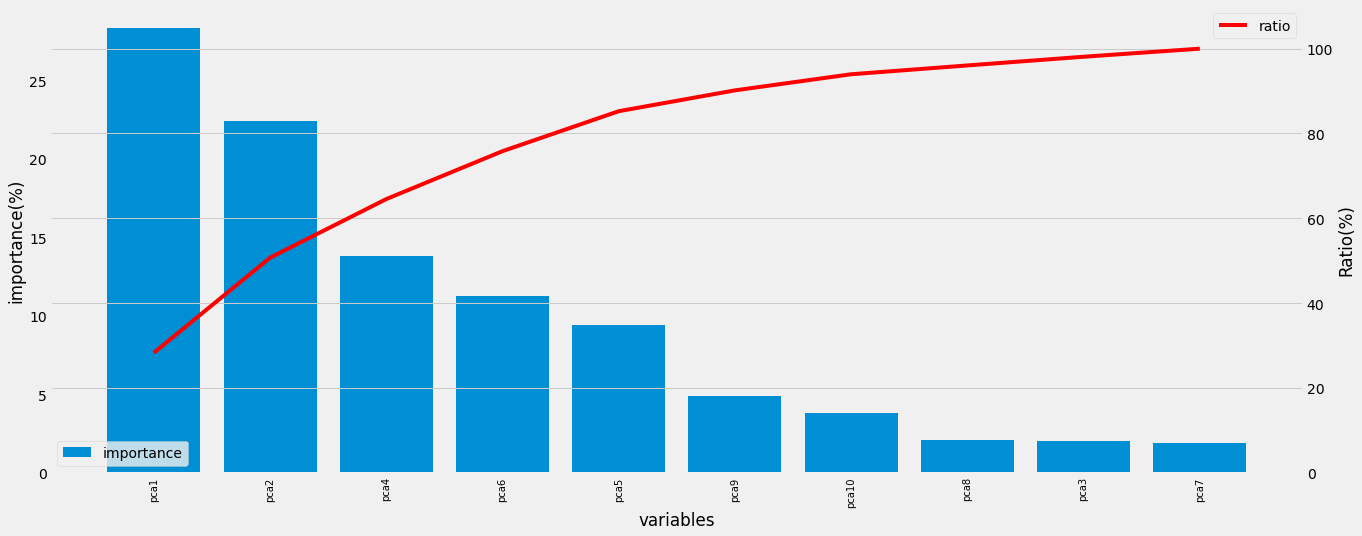

In [76]:
# Visualization with paret0 graph
forest_importance = pd.DataFrame({})
variables = []
feature_importance = []
for i in range(len(indices)):
    col = X.columns[indices[i]]
    impor = importance[indices[i]]
    variables.append(col)
    feature_importance.append(impor)
forest_importance["variables"] = variables
forest_importance["feature_importance"] = feature_importance
forest_importance["feature_importance"] = forest_importance["feature_importance"]*100
forest_importance["cumsum"] = forest_importance["feature_importance"].cumsum()


# Graph
fig, ax1 = plt.subplots(figsize=(20,8))
ax1.bar(forest_importance["variables"], forest_importance["feature_importance"], label="importance")
ax1.grid()
ax1.set_xlabel("variables")
ax1.tick_params(axis='x', rotation=90, labelsize=10)
ax1.set_ylabel("importance(%)")
plt.legend(loc='lower left')
ax2 = ax1.twinx()
ax2.plot(forest_importance["variables"], forest_importance["cumsum"], color="red", label="ratio")
ax2.set_ylim([0,110])
ax2.set_ylabel("Ratio(%)")
plt.legend(loc="upper right")

Hasil analisis komponen utama menunjukkan tidak ada perbedaan kinerja klasifikasi yang signifikan dari hasil analisis menggunakan seluruh data. Tetapi yang penting adalah bahwa beberapa informasi dikurangi ketika memilih jumlah komponen utama. Sangat berguna untuk mendapatkan hasil yang serupa meskipun demikian, karena mudah untuk memahami keseluruhan gambar untuk analisis.

Meskipun hanya sekitar 1%, namun kecenderungan over-fitting pada data uji lebih kecil dibandingkan dengan data latih. Hal ini dapat dilihat karena jumlah variabel telah berkurang dan model menjadi lebih kuat. Metode berbasis PCA ini lebih cocok untuk operasi aktual dan prediksi data yang tidak diketahui.

#Membandingkan metode pengambilan sampel¶

In [ ]:


Dari hasil analisis selama ini, ditemukan pentingnya membangun model dengan menggunakan seluruh data. Dalam hal ini, perlu diterapkan metode pengambilan sampel pada data yang tidak seimbang. Mulai sekarang, kami akan mengkonfirmasi efek dari beberapa metode ini dan mempertimbangkan yang terbaik. Prediksi menggunakan model hutan acak.

Metode yang dikonfirmasi adalah sebagai berikut:
Over sampling (Already confirmed)
Under sampling
SMOTE method
NearMiss method

**Under sampling**
Konfirmasikan hasil metode Under sampling di bawah kondisi yang sama seperti Oversampling, yang menangani semua data.

In [77]:
# Difine variables
X = train_std.iloc[:,:-2]
Y = train_std["class"]

# Data preprocessing, oversampling method
# create instance
rus = RandomUnderSampler(sampling_strategy="auto", random_state=10)

# train test data split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=10)

# Apply to data
X_resampled, y_resampled = rus.fit_sample(X_train, y_train)

In [78]:
# Create instance
forest  = RandomForestClassifier(n_estimators=10, random_state=10)

# parameters
param_range = [5, 10,15,20]
leaf = [60, 65, 70, 75]
criterion = ["entropy", "gini", "error"]
param_grid = [{"max_depth":param_range, "criterion":criterion, "max_leaf_nodes":leaf}]

# Optimization by Grid search, scoring is f1 score
gs = GridSearchCV(estimator=forest, param_grid=param_grid, scoring="f1", cv=5, n_jobs=-1)
gs = gs.fit(X_resampled, y_resampled)

print("gs best:%.3f" % gs.best_score_)
print("gs params:{}".format(gs.best_params_))

gs best:0.946
gs params:{'criterion': 'gini', 'max_depth': 10, 'max_leaf_nodes': 60}


In [79]:
# Prediction
gs_best = gs.best_estimator_

y_pred = gs_best.predict(X_test)

# Scores
print("Confusion_matrix = \n", confusion_matrix(y_true=y_test, y_pred=y_pred))
print("accuracy = %.3f" % accuracy_score(y_true=y_test, y_pred=y_pred))
print("precision = %.3f" % precision_score(y_true=y_test, y_pred=y_pred))
print("recall = %.3f" % recall_score(y_true=y_test, y_pred=y_pred))
print("f1_score = %.3f" % f1_score(y_true=y_test, y_pred=y_pred))

Confusion_matrix = 
 [[11172   630]
 [    9   189]]
accuracy = 0.947
precision = 0.231
recall = 0.955
f1_score = 0.372


**SMOTE**
mengonfirmasi metode SMOTE

In [80]:
# Difine variables
X = train_std.iloc[:,:-2]
Y = train_std["class"]

# Data preprocessing, oversampling method
# create instance
smote = SMOTE(sampling_strategy="auto", random_state=10)

# train test data split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=10)

# Apply to data
X_resampled, y_resampled = smote.fit_sample(X_train, y_train)

In [81]:
# Create instance
forest  = RandomForestClassifier(n_estimators=10, random_state=10)

# parameters
param_range = [10,15,20]
leaf = [80, 85, 90, 95]
criterion = ["entropy", "gini", "error"]
param_grid = [{"max_depth":param_range, "criterion":criterion, "max_leaf_nodes":leaf}]

# Optimization by Grid search, scoring is f1 score
gs = GridSearchCV(estimator=forest, param_grid=param_grid, scoring="f1", cv=5, n_jobs=-1)
gs = gs.fit(X_resampled, y_resampled)

print("gs best:%.3f" % gs.best_score_)
print("gs params:{}".format(gs.best_params_))

gs best:0.982
gs params:{'criterion': 'entropy', 'max_depth': 20, 'max_leaf_nodes': 95}


In [82]:
# Prediction
gs_best = gs.best_estimator_

y_pred = gs_best.predict(X_test)

# Scores
print("Confusion_matrix = \n", confusion_matrix(y_true=y_test, y_pred=y_pred))
print("accuracy = %.3f" % accuracy_score(y_true=y_test, y_pred=y_pred))
print("precision = %.3f" % precision_score(y_true=y_test, y_pred=y_pred))
print("recall = %.3f" % recall_score(y_true=y_test, y_pred=y_pred))
print("f1_score = %.3f" % f1_score(y_true=y_test, y_pred=y_pred))

Confusion_matrix = 
 [[11517   285]
 [   14   184]]
accuracy = 0.975
precision = 0.392
recall = 0.929
f1_score = 0.552


**NearMiss method**

In [83]:
# Difine variables
X = train_std.iloc[:,:-2]
Y = train_std["class"]

# Data preprocessing, oversampling method
# create instance
nem = NearMiss(sampling_strategy="auto")

# train test data split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=10)

# Apply to data
X_resampled, y_resampled = nem.fit_sample(X_train, y_train)

In [84]:
# Create instance
forest  = RandomForestClassifier(n_estimators=10, random_state=10)

# parameters
param_range = [5, 10,15,20]
leaf = [60, 65, 70, 75]
criterion = ["entropy", "gini", "error"]
param_grid = [{"max_depth":param_range, "criterion":criterion, "max_leaf_nodes":leaf}]

# Optimization by Grid search, scoring is f1 score
gs = GridSearchCV(estimator=forest, param_grid=param_grid, scoring="f1", cv=5, n_jobs=-1)
gs = gs.fit(X_resampled, y_resampled)

print("gs best:%.3f" % gs.best_score_)
print("gs params:{}".format(gs.best_params_))

gs best:0.996
gs params:{'criterion': 'entropy', 'max_depth': 5, 'max_leaf_nodes': 60}


In [85]:
# Prediction
gs_best = gs.best_estimator_

y_pred = gs_best.predict(X_test)

# Scores
print("Confusion_matrix = \n", confusion_matrix(y_true=y_test, y_pred=y_pred))
print("accuracy = %.3f" % accuracy_score(y_true=y_test, y_pred=y_pred))
print("precision = %.3f" % precision_score(y_true=y_test, y_pred=y_pred))
print("recall = %.3f" % recall_score(y_true=y_test, y_pred=y_pred))
print("f1_score = %.3f" % f1_score(y_true=y_test, y_pred=y_pred))

Confusion_matrix = 
 [[4348 7454]
 [   1  197]]
accuracy = 0.379
precision = 0.026
recall = 0.995
f1_score = 0.050


Kami mengkonfirmasi metode pengambilan sampel untuk data yang tidak seimbang dalam kondisi yang sama. Jika dibandingkan dengan skor f1 untuk melihat keseimbangan antara presisi dan recall, metode over sampling memberikan hasil terbaik untuk data ini. Di sisi lain, undersampling dan turunannya, metode Near Miss, memiliki nilai recall yang tinggi tetapi nilai presisi yang rendah. Ini mungkin karena kekuatan negatif dari negatif dikurangi dengan mengurangi jumlah kelas negatif dan harus dihindari untuk data ini.

# Model Pengklasifikasi berdasarkan hasil sejauh ini

Berdasarkan hasil analisis sampai saat ini, kami memutuskan untuk mengambil kebijakan berikut mengenai penanganan data variabel dalam klasifikasi.

(1) Kurangi jumlah variabel yang tidak penting, dengan nilai threshold fitur penting 0,6%. Saya dapat mengharapkan efek pada PCA juga, tetapi kali ini saya memutuskan untuk melanjutkan dengan pengurangan variabel berdasarkan kepentingan. (Mungkin kita bisa mengharapkan peningkatan lebih lanjut dengan menggabungkannya ...)
(2) Analisis klaster dilakukan pada variabel yang direduksi untuk membuat kelompok klaster yang kelas positif dan negatifnya relatif seimbang.
(3) Latih model prediktif pada seluruh data dan data klaster yang disempurnakan dan gabungkan hasilnya. Untuk model yang menangani seluruh data, metode pengambilan sampel untuk data tidak seimbang adalah over sampling yang digunakan.

# Classification prediction model¶

**Prediction model : I use LGBM classifier**
**Difine class and function, k-fold cross validation, learning and validation curve, confusion matrix, roc auc curve**


In [ ]:
class k_fold_cross_val:
    def __init__(self, X_train, y_train, estimator, cv):
        self.X_train = X_train
        self.y_train = y_train
        self.estimator = estimator
        self.cv = cv
        
    def cross_val_kfold(self):
        kfold = StratifiedKFold(n_splits=self.cv, random_state=10)
        self.kfold = kfold
        
        scores = []
        for train_idx, test_idx in self.kfold.split(self.X_train, self.y_train):
            self.estimator.fit(self.X_train[train_idx], self.y_train.values[train_idx])
            score = self.estimator.score(self.X_train[test_idx], self.y_train.values[test_idx])
            scores.append(score)
            print("Class: %s, Acc: %.3f" % (np.bincount(self.y_train.values[train_idx]), score))
            self.scores = scores
            
    def score(self):
        scores = cross_val_score(estimator=self.estimator, X=self.X_train, y=self.y_train, cv=self.cv, n_jobs=1)
        print("CV accuracy scores: %s" % self.scores)
        print("CV accuracy: %.3f +/- %.3f" % (np.mean(self.scores), np.std(self.scores)))
        
    def draw_roc_curve(self, X_test, y_test):
        self.X_test = X_test
        self.y_test = y_test
        
        mean_tpr=0
        mean_fpr=np.linspace(0,1,100)
        plt.figure(figsize=(10,6))
        for train_idx, test_idx in self.kfold.split(self.X_train, self.y_train):
            proba = self.estimator.fit(self.X_train[train_idx], self.y_train.values[train_idx]).predict_proba(self.X_train[test_idx])
            fpr, tpr, thresholds = roc_curve(y_true=self.y_train.values[test_idx], y_score=proba[:,1], pos_label=1)
            mean_tpr += interp(mean_fpr, fpr, tpr)
            mean_tpr[0] = 0
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, lw=1, label="ROC fold (area=%.2f)" %(roc_auc))
        
        # Line
        plt.plot([0,1], [0,1], linestyle='--', color=(0.6,0.6,0.6), label="random guessing")
        # plot mean of fpr, tpr roc_auc
        mean_tpr /= self.cv
        mean_tpr[-1] = 1.0
        mean_auc = auc(mean_fpr, mean_tpr)
        plt.plot(mean_fpr, mean_tpr, 'k--', label="mean ROC (area = %.2f)" % mean_auc, color="blue")
        # Line
        plt.plot([0,0,1], [0,1,1], lw=2, linestyle=':', color="black", label='perfect performance')
        plt.xlabel("false positive rate")
        plt.ylabel("true positive rate")
        plt.title("Receiver Operator Characteristic")
        plt.legend()


In [ ]:
def draw_learning_curve(estimator, X_train, y_train):
    # learning curve
    train_sizes, train_scores, test_scores = learning_curve(estimator=estimator, X=X_train, y=y_train, train_sizes=np.linspace(0.1,1,10), cv=10, n_jobs=1)
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    # plot
    plt.figure(figsize=(10,6))
    # train data
    plt.plot(train_sizes, train_mean, color="blue", marker='o', markersize=5, label='training accuracy')
    plt.fill_between(train_sizes, train_mean+train_std, train_mean-train_std, color="blue", alpha=0.15)
    # val data
    plt.plot(train_sizes, test_mean, color="green", marker='s', linestyle='--', markersize=5, label='validation accuracy')
    plt.fill_between(train_sizes, test_mean+test_std, test_mean-test_std, color="green", alpha=0.15)

    plt.grid()
    plt.xlabel("Number of trainig samples")
    plt.ylabel("Accuracy")
    plt.ylim([0.8,1.0])
    plt.title("Learning curve")
    plt.legend()

In [ ]:
def draw_validation_curve(estimator, X_train, y_train, param_name, param_range, xscale):
    # validation curve
    train_scores, test_scores = validation_curve(estimator=estimator, X=X_train, y=y_train, param_name=param_name, param_range=param_range, cv=10)
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)
    
    # plot
    plt.figure(figsize=(10,6))
    # train data
    plt.plot(param_range, train_mean, color="blue", marker='o', markersize=5, label='training accuracy')
    plt.fill_between(param_range, train_mean+train_std, train_mean-train_std, color="blue", alpha=0.15)
    # val data
    plt.plot(param_range, test_mean, color="green", marker='s', linestyle='--', markersize=5, label='validation accuracy')
    plt.fill_between(param_range, test_mean+test_std, test_mean-test_std, color="green", alpha=0.15)

    plt.grid()
    plt.xlabel("{}".format(param_name))
    if xscale=="log":
        plt.xscale("log")
    else:
        pass
    plt.ylabel("Accuracy")
    plt.ylim([0.8,1.0])
    plt.title("Validation curve")
    plt.legend()

In [88]:
def confmat_roccurve(X_test, y_test, y_pred, estimator):
    # create confusion matrix
    confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
    # visualiazation confusion matrix
    fig, ax = plt.subplots(1,2,figsize=(18,6))
    
    ax[0].matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
    for i in range(confmat.shape[0]):
        for j in range(confmat.shape[1]):
            ax[0].text(x=j, y=i, s=confmat[i,j], va="center", ha="center")
            
    ax[0].set_xlabel("predicted label")
    ax[0].set_ylabel("true label")
    ax[0].set_title("confusion matrix")
    # Score
    print("accuracy = %.3f" % accuracy_score(y_true=y_test, y_pred=y_pred))
    print("precision = %.3f" % precision_score(y_true=y_test, y_pred=y_pred))
    print("recall = %.3f" % recall_score(y_true=y_test, y_pred=y_pred))
    print("f1_score = %.3f" % f1_score(y_true=y_test, y_pred=y_pred))
    
    

In [ ]:
# visualization roc curve
    y_score = estimator.predict_proba(X_test)[:,1]
    fpr, tpr, thresholds = roc_curve(y_true=y_test, y_score=y_score)
    ax[1].plot(fpr, tpr, label="roc curve (area = %.3f)" % auc(fpr, tpr), color="blue")
    ax[1].plot([0,1], [0,1], linestyle='--', color=(0.6,0.6,0.6), label='random')
    ax[1].plot([0,0,1], [0,1,1], linestyle=':', color="black", label='perfect performance')
    ax[1].set_xlabel("false positive rate")
    ax[1].set_ylabel("true positive rate")
    ax[1].set_title("Receiver Operator Characteristic")
    ax[1].legend()

**Parameters**

In [89]:
best_col

array(['ck_000', 'ci_000', 'bt_000', 'bh_000', 'aq_000', 'bg_000',
       'az_000', 'ba_003', 'bv_000', 'bj_000', 'bx_000', 'cs_004',
       'cs_002', 'ba_001', 'ai_000', 'ag_002', 'dn_000', 'am_0', 'ay_008',
       'aa_000', 'al_000', 'bb_000', 'ee_005', 'cn_001', 'cn_002',
       'by_000', 'az_001', 'cn_000', 'ao_000', 'cs_001', 'ag_003',
       'ay_005', 'ag_001', 'ee_007', 'ay_007', 'ee_008', 'ay_006',
       'ee_004', 'ag_006', 'cn_007', 'ay_004', 'ay_009'], dtype=object)

#1st Prediksi Seluruh Data


In [90]:
# Selected parameters, feature importance threshold >=0.6
col = best_col
# Variables
X = train_std[col]
y = train_std["class"]

# train test data split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

# Apply over sampling method
ros = RandomOverSampler(sampling_strategy="auto", random_state=10)
X_resampled, y_resampled = ros.fit_sample(X_train, y_train)

# Study best parameter by Cross validation
# Instance
lgb_ = lgb.LGBMClassifier()

# prameters
max_depth = [5, 10, 15]
min_samples_leaf = [1,3,5,7]
min_samples_split = [4,6, 8, 10]

param_grid = [{"max_depth":max_depth,
               "min_samples_leaf":min_samples_leaf, "min_samples_split":min_samples_split}]

# Optimization by Grid search
gs = GridSearchCV(estimator=lgb_, param_grid=param_grid, scoring="f1", cv=5, n_jobs=-1)
gs = gs.fit(X_resampled, y_resampled)

print("gs best:%.3f" % gs.best_score_)
print("gs params:{}".format(gs.best_params_))

gs best:0.996
gs params:{'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 4}


In [91]:
# best params
gs_best_all = gs.best_estimator_

# Cross validation
cv = k_fold_cross_val(X_resampled.values, y_resampled, gs_best_all, 5)
cv.cross_val_kfold()

AttributeError: ignored

In [ ]:
# cross val score
cv.score()

In [ ]:
# learning curve
draw_learning_curve(gs_best_all, X_resampled, y_resampled)

In [ ]:
# validation curve
draw_validation_curve(gs_best_all, X_resampled, y_resampled, "max_depth", param_range, "")

In [ ]:
# cv training roc curve
cv.draw_roc_curve(X_resampled, y_resampled)


In [ ]:

# test data prediction
y_pred_all = gs_best_all.predict(X_test)

# Confusion matrix and ROC curve
confmat_roccurve(X_test, y_test, y_pred_all, gs_best_all)

# 2. Dengan prediksi data analisis cluster

In [ ]:
# Selected parameters, feature importance threshold >=0.6
col = best_col
# Variables
X = train_std.query("cluster!=0 & cluster!=4")[col]
y = train_std.query("cluster!=0 & cluster!=4")["class"]

# train test data split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

# Apply over sampling method
ros = RandomOverSampler(sampling_strategy="auto", random_state=10)
X_resampled, y_resampled = ros.fit_sample(X_train, y_train)

# Study best parameter by Cross validation
# Instance
lgb_ = lgb.LGBMClassifier()

# prameters
max_depth = [5, 10, 15]
min_samples_leaf = [1,3,5,7]
min_samples_split = [4,6, 8, 10]

param_grid = [{"max_depth":max_depth,
               "min_samples_leaf":min_samples_leaf, "min_samples_split":min_samples_split}]

# Optimization by Grid search
gs = GridSearchCV(estimator=lgb_, param_grid=param_grid, scoring="f1", cv=5, n_jobs=-1)
gs = gs.fit(X_resampled, y_resampled)

print("gs best:%.3f" % gs.best_score_)
print("gs params:{}".format(gs.best_params_))

In [ ]:
# best params
gs_best_cluster = gs.best_estimator_

# Cross validation
cv = k_fold_cross_val(X_resampled.values, y_resampled, gs_best_cluster, 5)
cv.cross_val_kfold()

In [ ]:
# cross val score
cv.score()

In [ ]:
# learning curve
draw_learning_curve(gs_best_cluster, X_resampled, y_resampled)

In [ ]:
# validation curve
draw_validation_curve(gs_best_cluster, X_resampled, y_resampled, "max_depth", param_range, "")

In [ ]:
# cv training roc curve
cv.draw_roc_curve(X_resampled, y_resampled)

In [ ]:
# test data prediction
y_pred_cluster = gs_best_cluster.predict(X_test)

# Confusion matrix and ROC curve
confmat_roccurve(X_test, y_test, y_pred_cluster, gs_best_cluster)

# Pengujian prediksi data Buat prediksi ensemble¶

**Preprocessing** 
Seluruh data

In [ ]:
# Selected parameters, feature importance threshold >=0.6
col = best_col
# Variables
X_Test = test_std[col]
y_Test = test_std["class"]

# test data prediction
y_Test_pred_all = gs_best_all.predict(X_Test)

**custer data**

In [ ]:
# Variables
X_Test_cluster = test_std.query("cluster!=0 & cluster!=4")[col]
y_Test_cluster = test_std.query("cluster!=0 & cluster!=4")["class"]

# test data prediction
y_Test_pred_cluster = gs_best_cluster.predict(X_Test_cluster)

# Perbandingan setiap hasil prediksi

In [ ]:
# Scores
# All data prediction
print("-"*30, "all data", "-"*30)
print("Confusion_matrix = \n", confusion_matrix(y_true=y_Test, y_pred=y_Test_pred_all))
print("accuracy = %.3f" % accuracy_score(y_true=y_Test, y_pred=y_Test_pred_all))
print("precision = %.3f" % precision_score(y_true=y_Test, y_pred=y_Test_pred_all))
print("recall = %.3f" % recall_score(y_true=y_Test, y_pred=y_Test_pred_all))
print("f1_score = %.3f" % f1_score(y_true=y_Test, y_pred=y_Test_pred_all))

# with cluster data prediction
print("-"*30, "cluster data", "-"*30)
print("Confusion_matrix = \n", confusion_matrix(y_true=y_Test_cluster, y_pred=y_Test_pred_cluster))
print("accuracy = %.3f" % accuracy_score(y_true=y_Test_cluster, y_pred=y_Test_pred_cluster))
print("precision = %.3f" % precision_score(y_true=y_Test_cluster, y_pred=y_Test_pred_cluster))
print("recall = %.3f" % recall_score(y_true=y_Test_cluster, y_pred=y_Test_pred_cluster))
print("f1_score = %.3f" % f1_score(y_true=y_Test_cluster, y_pred=y_Test_pred_cluster))

# Kesimpulan

Hasilnya sesuai dengan kedua baris ke data pelatihan, tetapi tidak berhasil mendeteksi positif ke data uji. Hasilnya adalah ada kecenderungan yang kuat untuk belajar berlebihan.
Hipotesis saya dan tindakan balasan sebagai penyebabnya adalah

Bukankah variabel data uji tidak terkandung dalam data pelatihan di ruang dimensi tinggi dan ada banyak elemen di luar? Oleh karena itu, ada kemungkinan bahwa bahkan variabel penting berkurang ketika variabel dikurangi. Penanggulangan: Turunkan ambang batas pengurangan variabel.
Masih banyak variabel, dan beberapa variabel dalam data latih yang memiliki pengaruh kuat terlalu kuat dalam data uji. Penanggulangan: Menyamakan pengaruh variabel dengan analisis komponen utama.
Untuk uji coba selanjutnya, saya akan mencoba dua di atas.